# Optimization of commercial offers for airline tickets

## SOLUTION PLANNING

### INPUT

#### **BUSINESS PROBLEM**: 

Uma companhia aérea deseja aumentar o número de passageiros que participam de seu programa de fidelidade, composto por três níveis de cartões: **Ametista**, **Ônix** e **Rubi**, sendo o Ametista o de menor e o Rubi o de maior benefício. 
O time de marketing forneceu uma base de novos clientes, porém o time comercial tem recursos limitados para abordar todos. 
Para otimizar as abordagens, o time comercial precisa saber qual a probabilidade de cada cliente assinar um dos três tipos de cartão.

**Objetivo**: Determinar a probabilidade de cada cliente assinar o cartão Ametista, Ônix ou Rubi, permitindo que o time comercial possa fazer ofertas mais eficientes e aumentar as taxas de conversão, maximizando o impacto das abordagens e otimizando os esforços de venda.


### FEATURES

1 - **loyalty_number**: Identificador único atribuído a cada cliente no programa de fidelidade. Este número é utilizado para rastrear a atividade e o histórico do cliente no programa.

2 - **year**: O ano em que a atividade do cliente foi registrada. Esta variável é importante para análises temporais e tendências ao longo dos anos.

3 - **month**: O mês em que a atividade do cliente foi registrada. Assim como o ano, é útil para análises mensais de comportamento e tendências.

4 - **flights_booked**: Número total de voos que o cliente reservou durante um período específico. Essa métrica ajuda a entender a frequência de viagens dos clientes.

5 - **flights_with_companions**: Número de voos que o cliente reservou com acompanhantes. Esta informação pode indicar o comportamento social do cliente e sua lealdade ao programa.

6 - **total_flights**: Total de voos que o cliente fez, incluindo voos reservados e voos em que o cliente foi um acompanhante. Essa métrica fornece uma visão abrangente do envolvimento do cliente com a companhia aérea.

7 - **distance**: A distância total (geralmente em milhas ou quilômetros) que o cliente voou em suas viagens. Isso ajuda a medir a atividade do cliente em termos de viagens realizadas.

8 - **points_accumulated**: Total de pontos acumulados pelo cliente no programa de fidelidade, geralmente resultantes de voos e outras atividades. Os pontos acumulados podem ser trocados por recompensas.

9 - **points_redeemed**: Total de pontos que o cliente resgatou durante um determinado período. Essa métrica indica como os clientes estão utilizando os benefícios do programa.

10 - **dollar_cost_points_redeemed**: Valor monetário equivalente aos pontos resgatados pelo cliente. Isso pode ajudar a avaliar o custo do programa de fidelidade para a empresa.

11 - **country**: País em que o cliente reside. Essa informação é útil para segmentação de clientes e para entender a geografia do mercado.

12 - **province**: Província ou estado em que o cliente reside. Assim como o país, é útil para análises regionais.

13 - **city**: Cidade onde o cliente reside. Essa informação pode ajudar a personalizar ofertas e estratégias de marketing.

14 - **postal_code**: Código postal da área de residência do cliente. Isso pode ser usado para segmentação geográfica mais precisa e para análises de localização.

15 - **gender**: Gênero do cliente (masculino, feminino, etc.). Essa variável é relevante para análises demográficas e para entender as preferências de diferentes grupos.

16 - **education**: Nível educacional do cliente (por exemplo, ensino médio, graduação, pós-graduação). Essa informação pode ajudar a segmentar o público-alvo e entender seu perfil socioeconômico.

17 - **salary**: Renda do cliente. Essa métrica pode ser usada para entender o poder aquisitivo do cliente e segmentar ofertas.

18 - **marital_status**: Estado civil do cliente (casado, solteiro, etc.). Essa informação pode influenciar o comportamento de compra e a lealdade ao programa.

19 - **loyalty_card**: Tipo de cartão de fidelidade que o cliente possui (por exemplo, Rubi, Ônix, Ametista). Isso pode ajudar a segmentar os clientes de acordo com os benefícios que eles têm.

20 - **clv**: Valor do tempo de vida do cliente (Customer Lifetime Value), que representa a receita total esperada que um cliente gerará durante seu relacionamento com a empresa. É uma métrica importante para avaliar a rentabilidade.

21 - **enrollment_type**: Tipo de inscrição do cliente no programa de fidelidade (por exemplo, nova inscrição, reativação). Essa informação ajuda a entender a motivação dos clientes para se inscreverem no programa.

22 - **enrollment_year**: O ano em que o cliente se inscreveu no programa de fidelidade. Isso pode ajudar a avaliar a lealdade e a permanência no programa ao longo do tempo.

23 - **enrollment_month**: O mês em que o cliente se inscreveu no programa. Assim como o ano, é útil para análises de tendências de inscrição e comportamento ao longo do tempo.

### OUTPUT

#### **Relatório contendo as respostas para as seguintes questões de negócio:**

1 . Quem são os clientes com maior probabilidade de assinar cada cartão?

2 . Qual é a distribuição percentual da probabilidade de assinatura para os três níveis de cartão (Ametista, Ônix, Rubi)?

3 . Quais as características mais relevantes dos clientes que influenciam na decisão de assinatura?

4 . Quais as taxas de conversão esperadas ao utilizar as probabilidades como critério de abordagem?

5 . Qual o impacto estimado de receita com a conversão dos clientes, levando em consideração os três tipos de cartões?

6 . Quais são os principais fatores que aumentam ou diminuem a probabilidade de um cliente assinar o cartão Rubi (o de maior valor)?

### TASKS

1 . Quem são os clientes com maior probabilidade de assinar cada cartão?

**Analisar os perfis de clientes para entender o comportamento e determinar, por exemplo:**

 - Histórico de compras de passagens.

 - Frequência de uso dos serviços da companhia aérea.

 - Preferências por rotas e destinos.

 - Gasto médio por transação.

 - Engajamento em outros canais de relacionamento (como redes sociais ou newsletter).
 
 - Quantos clientes possuem alta probabilidade de assinatura e qual o percentual correspondente?
 
 - Determinar a quantidade total de clientes com alta probabilidade para cada cartão (Ametista, Ônix, Rubi).
 
 - Calcular o percentual de cada grupo de clientes dentro da base total.

2 . Quais são as características mais relevantes dos clientes?

 - Idade, região de residência, classe econômica.
 
 - Rendimento, frequência de viagens.

 - Nível de engajamento com a marca e com programas de fidelidade em geral.

3 . Qual a expectativa de faturamento a partir da conversão dos clientes?

 - Calcular o valor esperado de receita baseado na probabilidade de assinatura de cada cartão e no ticket médio dos clientes.
 - Aplicar modelos de séries temporais (ARIMA, Holt-Winters) para prever a evolução da receita nos meses subsequentes.

4 . Quais as condições para o cliente ser considerado um potencial assinante?

 - Critérios de segmentação que identifiquem clientes com alta propensão de assinar o cartão de maior valor, com base no comportamento de compra, histórico de viagens e frequência de interação com a companhia.

5 . Qual a taxa de conversão esperada usando as probabilidades?

 - Realizar testes para validar a eficácia da abordagem baseada em probabilidades.

 - Estabelecer uma métrica de sucesso baseada no número de assinaturas efetivadas versus o número de contatos realizados.

6 . Quais ações o time de marketing pode realizar para aumentar o número de adesões?

 - Oferecer promoções ou descontos progressivos, conforme a propensão do cliente a assinar o programa de fidelidade.

 - Disponibilizar benefícios exclusivos para os primeiros meses de assinatura.
 
 - Usar segmentação e personalização na comunicação, de acordo com o perfil de cada cliente.


# 1.0 - IMPORTS

## 1.1 - LIBRARIES

In [1]:
import gdown
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import pearsonr
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 1.2 - LOAD DATA

In [2]:
# URL do arquivo no Google Drive
url = "https://drive.google.com/uc?id=1HbqPT-GehWmmXnuXegbxx5cnjiXionvP"

# Caminho local onde você deseja salvar o arquivo (substitua pelo seu diretório)
output_path = "../data/dataset.db"  # Altere aqui

# Realiza o download
gdown.download(url, output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1HbqPT-GehWmmXnuXegbxx5cnjiXionvP
To: /home/erickvieira/Documentos/repos/flight_project/data/dataset.db
100%|██████████| 12.6M/12.6M [00:01<00:00, 10.9MB/s]


'../data/dataset.db'

In [3]:
db_path = "../data/dataset.db"

# Conectar ao banco de dados
conn = sqlite3.connect(db_path)

# Criar o cursor para consultas
cursor = conn.cursor()

# Realizar a consulta
query = "SELECT * FROM flight_activity fa LEFT JOIN flight_loyalty_history flh ON fa.loyalty_number = flh.loyalty_number"
df_raw = pd.read_sql_query(query, conn)

# Fechar a conexão
conn.close()

df_raw.to_csv('../data/flight_data.csv', index=False)

## 1.3 - HELPER FUNCTIONS

### 1.3.1 - PLOT DIMENSIONS

In [4]:
sns.set_theme(rc = {'figure.figsize':(13,5)})

### 1.3.2 - OUTLIERS VOLUMETRY

In [5]:
def outliers_volumetry(df):
    # Selecionar apenas as colunas numéricas
    df_num = df.select_dtypes(include=['float64', 'int64'])
    outlier = []

    # Iterar pelas colunas numéricas
    for i in df_num.columns:
        q1 = np.quantile(df_num[i], 0.25)
        q3 = np.quantile(df_num[i], 0.75)
        interquartile_distance = q3 - q1
        upper_limit = q3 + 1.5 * interquartile_distance
        lower_limit = q1 - 1.5 * interquartile_distance

        # Contar outliers
        outliers = ((df_num[i] > upper_limit) | (df_num[i] < lower_limit)).sum()

        outlier.append(outliers)

    # Criar um DataFrame com os resultados
    df_outlier = pd.DataFrame()
    df_outlier['attributes'] = df_num.columns
    df_outlier['quantity'] = outlier
    df_outlier['percentual'] = np.round((df_outlier['quantity'] / len(df_num)) * 100, 1)

    return df_outlier

def outliers_boxplot(data, cols, rows):
    # Creating the subplots for the dashbord of the boxplot
    df_num = data.select_dtypes(include = ['int', 'float'])
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Volumetry of Outliers", fontsize=18)

    # loop through the length of pointer and keep track of index
    for n, pointer in enumerate(df_num.columns):
        
        # add a new subplot iteratively
        ax = plt.subplot(rows, cols, n + 1)

        # create a boxplot for the pointer on the new subplot axis
        df_num[pointer].plot(kind='box', ax=ax)

        # chart formatting
        ax.set_title(pointer.upper())
        ax.set_xlabel("")

    plt.show()

# 2.0 - DATA DESCRIPTION

In [6]:
df2 = df_raw.copy()

## 2.1 - DATA DIMENSIONS

In [7]:
print('Numero de colunas: {}'.format(df2.shape[1]))
print('Numero de linhas: {}'.format(df2.shape[0]))
print('\nQuantidade de dados unicos para cada feature:')
df2.apply(lambda x: x.nunique())

Numero de colunas: 26
Numero de linhas: 405624

Quantidade de dados unicos para cada feature:


loyalty_number                 16737
year                               2
month                             12
flights_booked                    22
flights_with_companions           12
total_flights                     33
distance                        4746
points_accumulated              1549
points_redeemed                  587
dollar_cost_points_redeemed       49
loyalty_number                 16737
country                            1
province                          11
city                              29
postal_code                       55
gender                             2
education                          5
salary                          5890
marital_status                     3
loyalty_card                       3
clv                             7984
enrollment_type                    2
enrollment_year                    7
enrollment_month                  12
cancellation_year                  6
cancellation_month                12
dtype: int64

## 2.2 - RENAME COLUNS

In [8]:
df2.columns

Index(['loyalty_number', 'year', 'month', 'flights_booked',
       'flights_with_companions', 'total_flights', 'distance',
       'points_accumulated', 'points_redeemed', 'dollar_cost_points_redeemed',
       'loyalty_number', 'country', 'province', 'city', 'postal_code',
       'gender', 'education', 'salary', 'marital_status', 'loyalty_card',
       'clv', 'enrollment_type', 'enrollment_year', 'enrollment_month',
       'cancellation_year', 'cancellation_month'],
      dtype='object')

## 2.3 - DATA TYPES

In [9]:
df2.dtypes

loyalty_number                   int64
year                             int64
month                            int64
flights_booked                   int64
flights_with_companions          int64
total_flights                    int64
distance                         int64
points_accumulated             float64
points_redeemed                  int64
dollar_cost_points_redeemed      int64
loyalty_number                   int64
country                         object
province                        object
city                            object
postal_code                     object
gender                          object
education                       object
salary                         float64
marital_status                  object
loyalty_card                    object
clv                            float64
enrollment_type                 object
enrollment_year                  int64
enrollment_month                 int64
cancellation_year              float64
cancellation_month       

## 2.4 - CHECK DUPLICATE

In [10]:
# Identificar as colunas duplicadas
df2.columns[df2.columns.duplicated()].tolist()

['loyalty_number']

In [11]:
df2 = df2.loc[:, ~df2.columns.duplicated()]

## 2.5 - NA VOLUMETRY

In [12]:
df_total = pd.DataFrame(np.round(df2.isna().sum())).reset_index()
df_percentual = pd.DataFrame(np.round(df2.isna().mean()*100)).reset_index()
df_total.columns = ['feature', 'total']
df_percentual.columns = ['feature', 'percentual']

df_total = df_total.drop_duplicates(subset=['feature'])
df_percentual = df_percentual.drop_duplicates(subset=['feature'])

# Realizando o merge
df_result = pd.merge(df_total, df_percentual, how = 'inner', on='feature')
df_result

,feature,total,percentual
0,loyalty_number,0,0.0
1,year,0,0.0
2,month,0,0.0
3,flights_booked,0,0.0
4,flights_with_companions,0,0.0
5,total_flights,0,0.0
6,distance,0,0.0
7,points_accumulated,0,0.0
8,points_redeemed,0,0.0
9,dollar_cost_points_redeemed,0,0.0


### 2.5.1 - NAN ANALYSIS

Iremos deletar da base de dados as features **cancellation_year** e **cancellation_month**, pois correspondem ambas a 355.560, ou seja, 88% dos dados faltantes dessa feature. logo não será viavel reaproveita-la de alguma forma.

In [13]:
df2 = df2.drop(columns = ['cancellation_year', 'cancellation_month'])

Observamos a feature **salary** possui um volume relativamente baixo de NaN, representando apenas 102672, ou seja, 25% desses dados.<br>
Nesse contexto sera analisado os salarios baseados no grau escolar, para assim ter um parametro mais proximo de salario de acordo com os dados que são fornecidos:

In [14]:
df_na = df2[['education', 'salary']]
#Verificando dados que não possuem NA dentre a feature 'education'
print('Grau escolar de dados não faltantes:\n\n {}'.format(df_na[~df_na['salary'].isna()]['education'].value_counts()))
print('\nGrau escolar de dados faltantes:\n\n {}'.format(df_na[df_na['salary'].isna()]['education'].value_counts()))

Grau escolar de dados não faltantes:

 education
Bachelor                253752
High School or Below     19008
Doctor                   17856
Master                   12336
Name: count, dtype: int64

Grau escolar de dados faltantes:

 education
College    102672
Name: count, dtype: int64


Após esta avaliação, é observável que dentre os clientes com o grau escolar **College** há integralmente todo volume de NaN.<br> 
Vamos utilizar de base analítica experimental a média e mediana de cada grau escolar de cada cliente para identificar uma possivel abordagem para esse dado

In [15]:
#Filtrando os dados
df_filter = df_na.loc[df_na['education'] != 'College']
# Calculando a média e mediana de 'salary' para cada categoria de 'education'
df_result = df_filter.groupby('education')['salary'].agg(['mean', 'median']).reset_index()
df_result = df_result.sort_values(by = 'mean', ascending=True)
# Exibindo o resultado
df_result = pd.DataFrame(df_result)
df_result


,education,mean,median
2,High School or Below,60986.544192,61806.0
0,Bachelor,72476.211860,71971.0
3,Master,103767.494163,105487.0
1,Doctor,178335.439516,180440.0


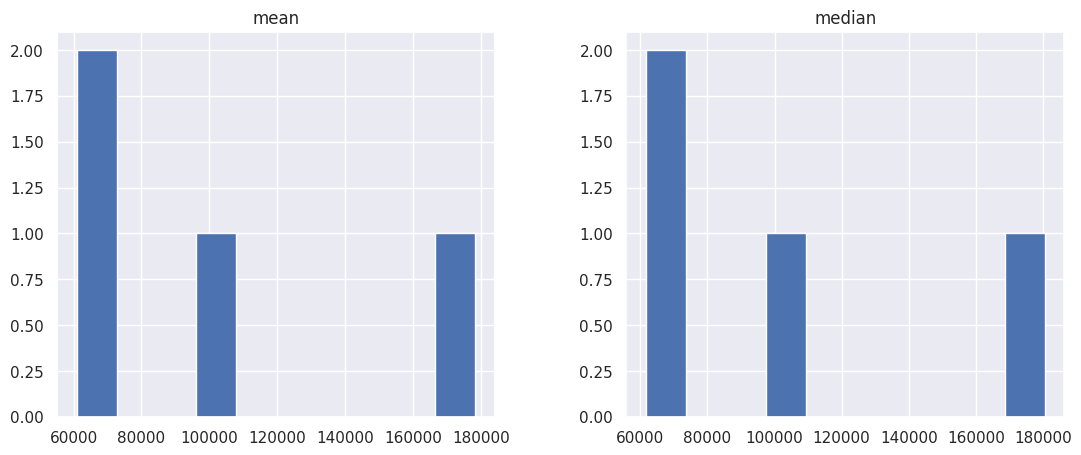

In [16]:
df_result.hist()
plt.show()

Dado a proporção de NaN da feature **Salary** representar 25% dos dados da nossa base, iremos então substituir a nivel e experimento os dados NaN por um range entre a média e a mediana da feature **Education** que possui grau escolar **Bachelor**, afim de manter uma uniformidade e variabilidade entre os dados sem agregar viés.

In [17]:
#Filtrando dados
df_calc_na = df_filter.loc[df_filter['education'] == 'Bachelor']

#calculando as medidas
mean_salary = df_calc_na['salary'].mean()
median_salary = df_calc_na['salary'].median()

#calculando a quantidade de NAN
total_na = df2['salary'].isna().sum()

#definindo limites minimos e maximos
lower_limit = min(mean_salary, median_salary)
upper_limit = max(mean_salary, median_salary)

#Gerando os valores dentro do range de NA com base nos limites
fill_values = np.random.uniform(lower_limit, upper_limit, size = total_na)

#Prenchendo os valores
df2.loc[df2['salary'].isna(), 'salary'] = fill_values

## 2.6 - OUTLIERS VOLUMETRY

In [18]:
outliers_volumetry(df2)

,attributes,quantity,percentual
0,loyalty_number,0,0.0
1,year,0,0.0
2,month,0,0.0
3,flights_booked,528,0.1
4,flights_with_companions,71560,17.6
5,total_flights,1984,0.5
6,distance,146,0.0
7,points_accumulated,127,0.0
8,points_redeemed,24181,6.0
9,dollar_cost_points_redeemed,24181,6.0


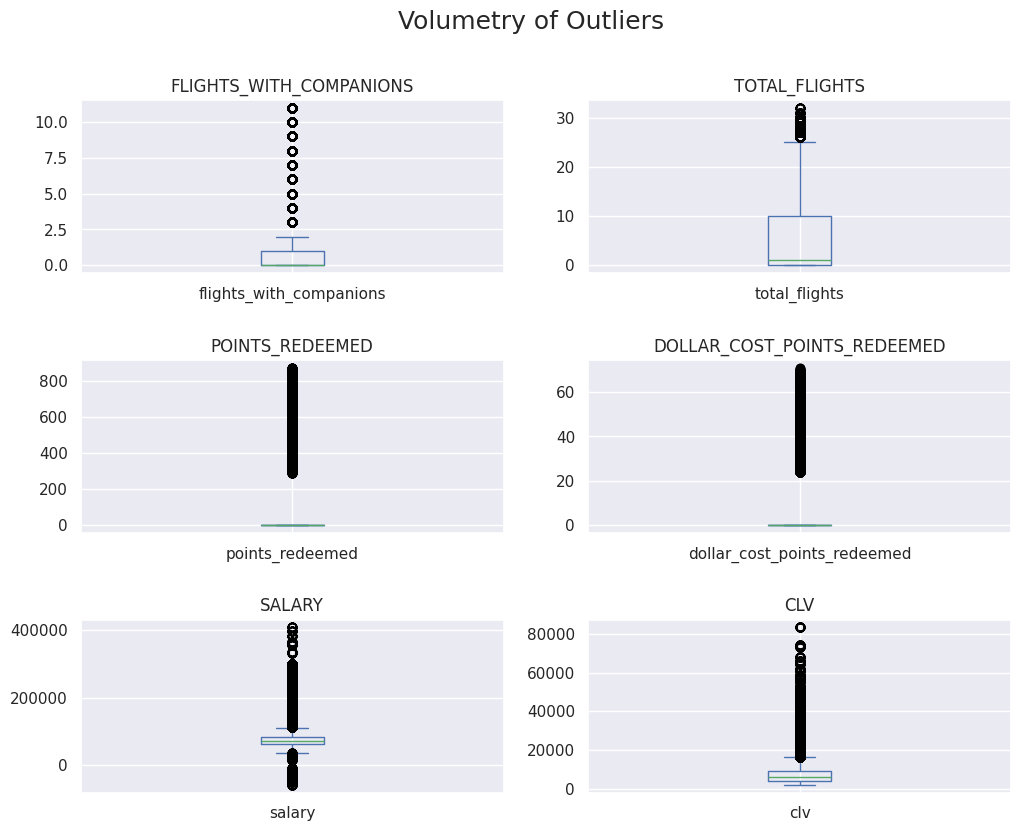

In [19]:
df_filter = df2[['flights_with_companions', 'total_flights', 'points_redeemed', 'dollar_cost_points_redeemed', 'salary', 'clv']]
outliers_boxplot(df_filter, 2, 3)

In [20]:
df2.loc[df2['salary'] <= 0]

,loyalty_number,year,month,flights_booked,flights_with_companions,total_flights,distance,points_accumulated,points_redeemed,dollar_cost_points_redeemed,...,postal_code,gender,education,salary,marital_status,loyalty_card,clv,enrollment_type,enrollment_year,enrollment_month
293,115505,2017,1,0,0,0,0,0.0,0,0,...,A1C 6H9,Male,Bachelor,-10605.0,Married,Nova,5860.17,2018 Promotion,2018,4
961,152016,2017,1,0,0,0,0,0.0,0,0,...,P1J 8T7,Female,Bachelor,-58486.0,Married,Aurora,5067.21,2018 Promotion,2018,2
1740,194065,2017,1,0,0,0,0,0.0,0,0,...,M5V 1G5,Female,Bachelor,-31911.0,Married,Nova,2888.85,2018 Promotion,2018,2
2111,212128,2017,1,3,0,3,1959,195.0,0,0,...,P2T 6G3,Male,Bachelor,-49001.0,Married,Nova,3130.68,2018 Promotion,2018,2
2464,232755,2017,1,0,0,0,0,0.0,0,0,...,V1E 4R6,Female,Bachelor,-46683.0,Single,Nova,4787.81,2018 Promotion,2018,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400664,734647,2018,12,15,0,15,1440,144.0,0,0,...,S1J 3C5,Male,Bachelor,-46303.0,Married,Nova,11280.73,2018 Promotion,2018,4
401739,790475,2018,12,7,1,8,1056,105.0,0,0,...,K8V 4B2,Female,Bachelor,-34079.0,Married,Nova,12913.50,2018 Promotion,2018,2
403876,906428,2018,12,13,0,13,2912,291.0,0,0,...,Y2K 6R0,Male,Bachelor,-57297.0,Married,Star,10018.66,2018 Promotion,2018,4
404318,430398,2018,12,5,5,10,660,66.0,539,44,...,A1C 6H9,Male,Bachelor,-17534.0,Married,Nova,49423.80,2018 Promotion,2018,3


Identificado que a feature **Salary** possui valores negativos, e dentro de um contexto logico esse dado não esta dentro d um escopo real. Então iremos deixa-lo positivo

In [21]:
df2['salary'] = df2['salary'].apply(lambda x: np.abs(x) if x <= 0 else x)

## 2.7 - STATICTICAL DESCRIPTIVE

In [22]:
df2_num = pd.DataFrame()
df2_cat = pd.DataFrame()

df2_num = df2.select_dtypes(exclude = ('object', 'datetime'))
df2_cat = df2.select_dtypes(include = 'object')

In [23]:
# Tendence central:
# - Mean
# - Median

central_tendence1 = pd.DataFrame(df2_num.apply(lambda x: np.mean(x))).T
central_tendence2 = pd.DataFrame(df2_num.apply(lambda x: np.median(x))).T

# Dispersion:
# - Max
# - Min
# - Range
# - Standart Deviation
# - Skew
# - Kurtosis

dispersion1 = pd.DataFrame(df2_num.apply(lambda x: np.std(x))).T
dispersion2 = pd.DataFrame(df2_num.apply(min)).T
dispersion3 = pd.DataFrame(df2_num.apply(max)).T
dispersion4 = pd.DataFrame(df2_num.apply(lambda x: x.min() - x.max())).T
dispersion5 = pd.DataFrame(df2_num.apply(lambda x: x.skew())).T
dispersion6 = pd.DataFrame(df2_num.apply(lambda x: x.kurtosis())).T

# Concatenating the dataframes

metrics = pd.concat([central_tendence1, central_tendence2, dispersion1, dispersion2, dispersion3, dispersion4, dispersion5, dispersion6]).T.reset_index()
metrics.columns = ['attribuites', 'mean', 'median', 'standart deviation', 'min', 'max', 'range', 'skew', 'kurtosis']
metrics

,attribuites,mean,median,standart deviation,min,max,range,skew,kurtosis
0,loyalty_number,550037.873084,550834.000000,258934.967787,100018.00,999986.00,-899968.00,-0.001403,-1.190652
1,year,2017.500000,2017.500000,0.500000,2017.00,2018.00,-1.00,0.000000,-2.000010
2,month,6.500000,6.500000,3.452053,1.00,12.00,-11.00,0.000000,-1.216783
3,flights_booked,4.115052,1.000000,5.225512,0.00,21.00,-21.00,1.038318,-0.078886
4,flights_with_companions,1.031805,0.000000,2.076867,0.00,11.00,-11.00,2.154785,4.010290
5,total_flights,5.146858,1.000000,6.521219,0.00,32.00,-32.00,1.087219,0.222311
6,distance,1208.880059,488.000000,1433.153553,0.00,6293.00,-6293.00,0.837370,-0.496957
7,points_accumulated,123.692721,50.000000,146.599651,0.00,676.50,-676.50,0.833471,-0.514460
8,points_redeemed,30.696872,0.000000,125.485895,0.00,876.00,-876.00,4.087605,15.790254
9,dollar_cost_points_redeemed,2.484503,0.000000,10.150025,0.00,71.00,-71.00,4.079823,15.704409


# 3.0 - FEATURE ENGINNERING

In [24]:
df3 = df2.copy()

## 3.1 - DERIVED FEATURES

**Flight Frequency**:
- A frequência de voos pode ser calculada a partir do número de voos reservados e o tempo de fidelização:

In [25]:
df3['flight_frequency'] = df3['total_flights'] / (df3['year'] - df3['enrollment_year'])

**Companion Flight Ratio**: 
- Proporção de voos com acompanhantes em relação ao total de voos:

In [26]:
df3['companion_flight_ratio'] = df3['flights_with_companions'] / df3['total_flights']

**Points Efficiency**: 
- Eficiência dos pontos acumulados em relação à distância percorrida:

In [27]:
df3['points_efficiency'] = df3['points_accumulated'] / df3['distance']

**Points Redeemed Ratio**: 
- Proporção de pontos resgatados em relação aos pontos acumulados

In [28]:
df3['points_redeemed_ratio']  = df3['points_redeemed']  / df3['points_accumulated'] 

**Flight Distance per Year**: 
- Média de distância percorrida por ano de fidelização:

In [29]:
df3['distance_per_year']  = df3['distance']  / (df3['year'] - df3['enrollment_year'])

**Cost per Redeemed Point**: 
- Custo por ponto resgatado:

In [30]:
df3['cost_per_point'] = df3['dollar_cost_points_redeemed'] / df3['points_redeemed']

**Flight Participation by Loyalty Card:**
- Uma flag indicando se o número de voos ou a acumulação de pontos é significativamente influenciada pelo uso de um cartão de fidelidade:

In [31]:
df3['threshold'] = df3['points_accumulated'].mean()  # Exemplo: definir threshold como a média dos pontos acumulados
df3['loyalty_influence'] = np.where((df3['loyalty_card'] == 1) & (df3['points_accumulated'] > df3['threshold']), 1, 0)


**Flight and Points Correlation**: 
- Uma relação entre os voos reservados e os pontos acumulados para determinar a intensidade de uso do programa de fidelidade:

In [32]:
df3['flight_points_ratio'] = df3['points_accumulated'] / df3['flights_booked']

Ajustando os tipos de cartão fidelidade para uma categoria mais otimizada

In [33]:
df3['loyalty_card'] = df3['loyalty_card'].replace({'Star':'Ametista', 'Nova': 'Onix', 'Aurora':'Rubi'})

## 3.2 - NA VOLUMETRY

Avaliando a volumetria de dados NaN após a derivação das features afim de manter a consistencia dos dados

In [34]:
df_na = df3.columns[df3.isna().any()]
df_na = df3[df_na]

df_na_total = pd.DataFrame(df_na.isna().sum()).reset_index()
df_na_percentual = pd.DataFrame(df_na.isna().mean()*100).reset_index()
df_na_percentual = df_na_percentual.apply(lambda x: np.round(x, 2))
df_result = pd.merge(df_na_total, df_na_percentual, on = 'index', how = 'left')
df_result.columns = ['features', 'total', '%']
df_result

,features,total,%
0,flight_frequency,43471,10.72
1,companion_flight_ratio,197992,48.81
2,points_efficiency,197992,48.81
3,points_redeemed_ratio,197992,48.81
4,distance_per_year,43471,10.72
5,cost_per_point,381443,94.04
6,flight_points_ratio,197992,48.81


In [35]:
df3 = df3.fillna(0)

# 4.0 - EXPLORATORY DATA ANALYSIS

In [36]:
df4 = df3.copy()

## 4.1 - UNIVARIATE ANALYSIS

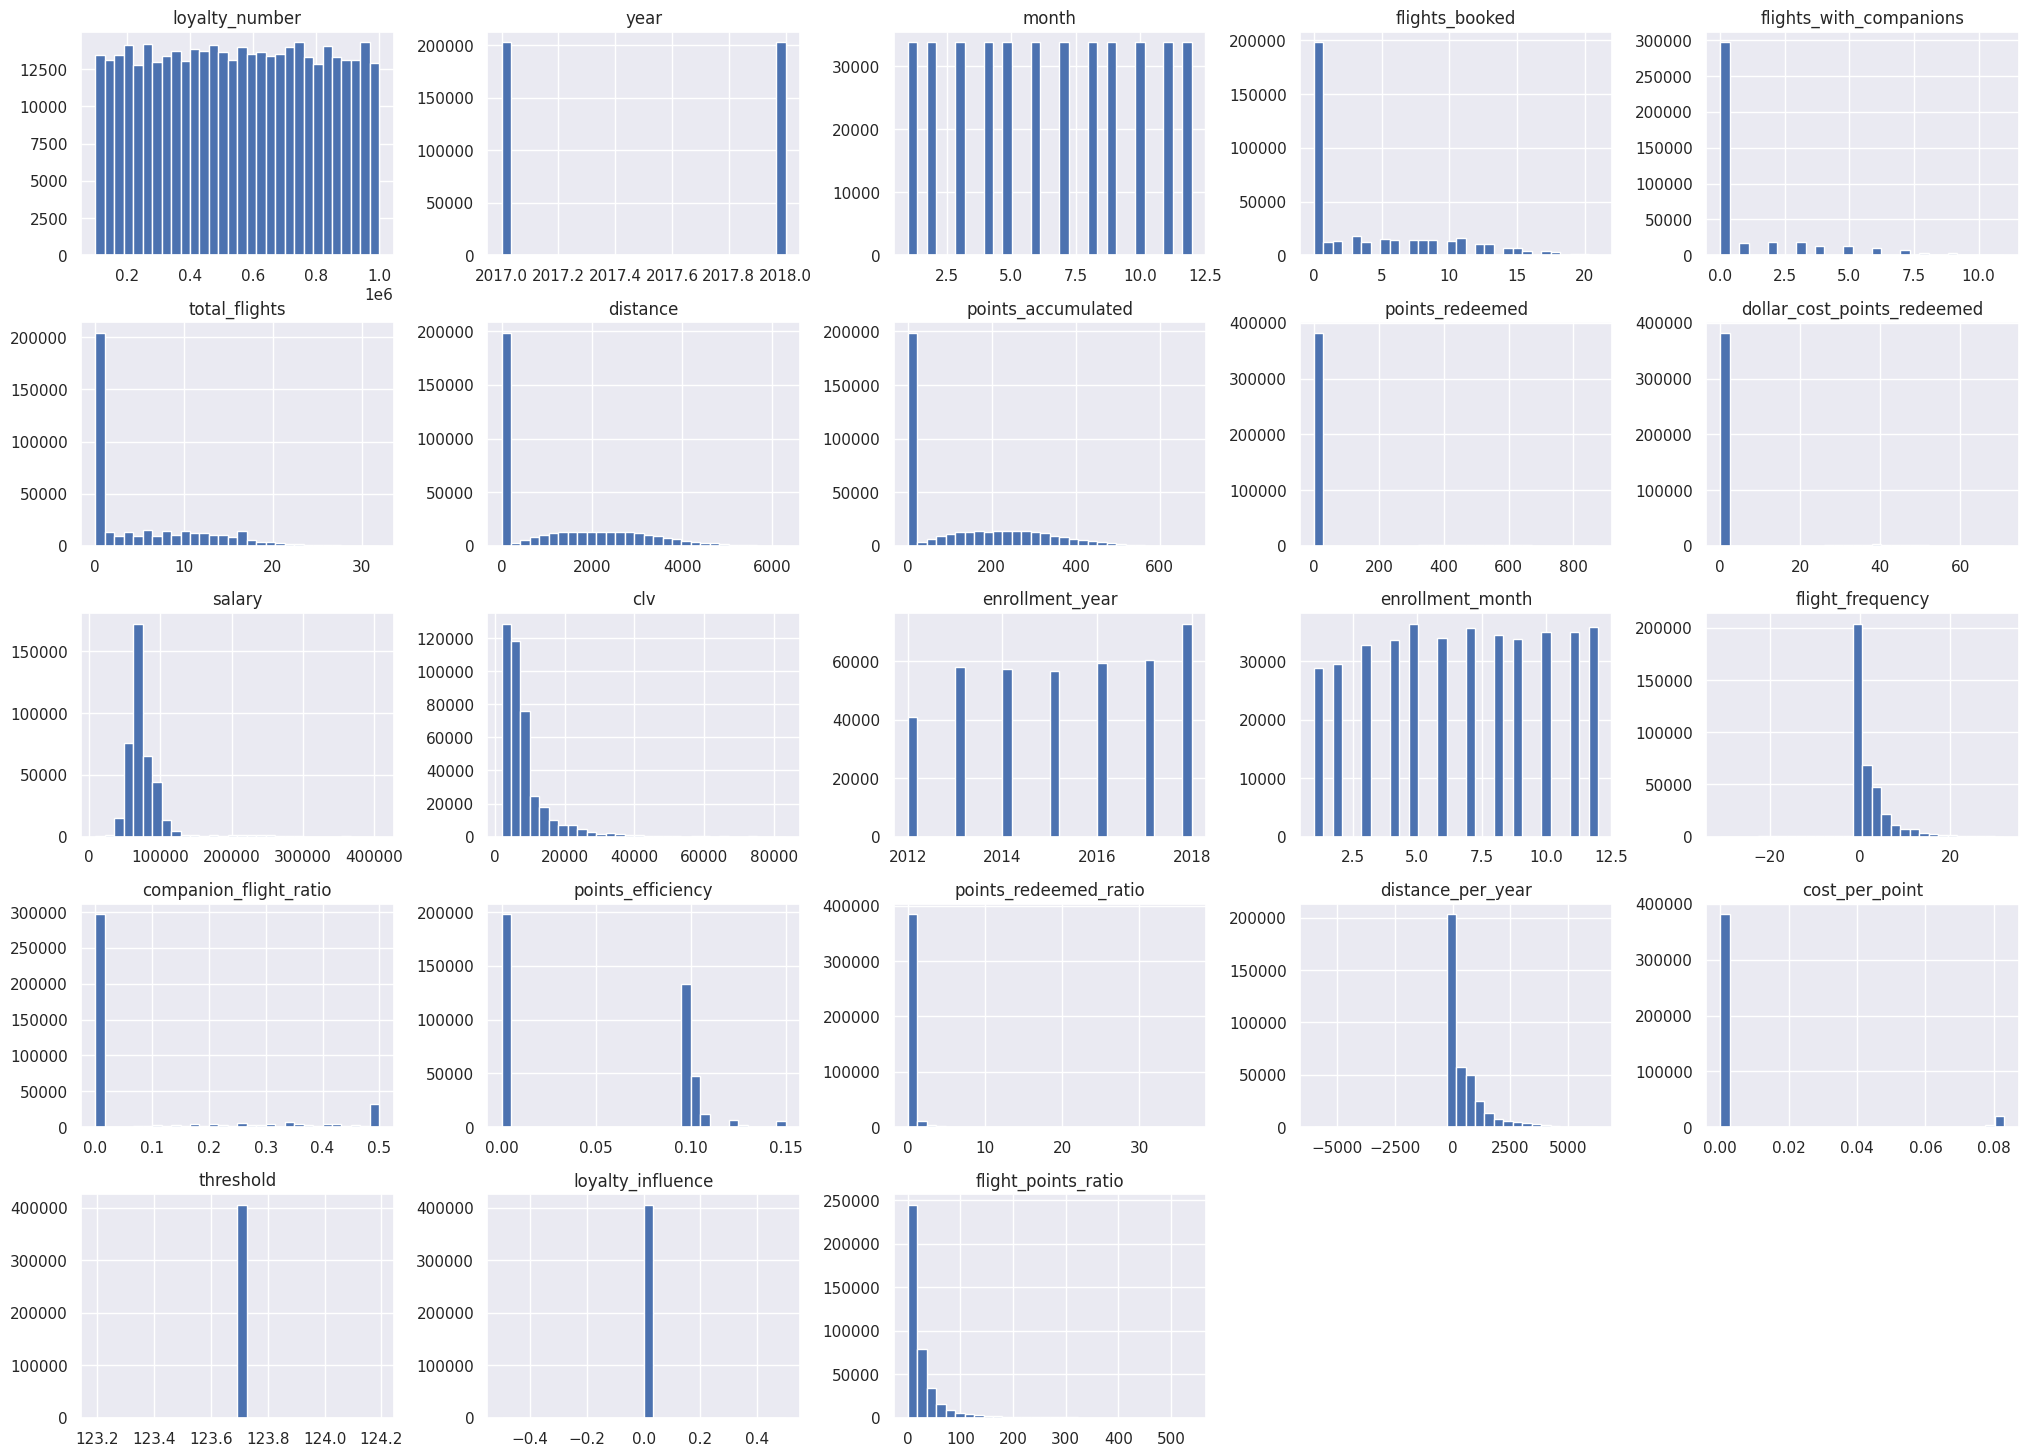

In [37]:
df_hist = df4.replace([np.inf, -np.inf], np.nan)
df_hist.hist(figsize=(25,18), bins=30)
plt.show()

## 4.2 - BIVARIATE ANALYSIS

### 4.2.1 - Proporção de clientes e pontuação por fidelização

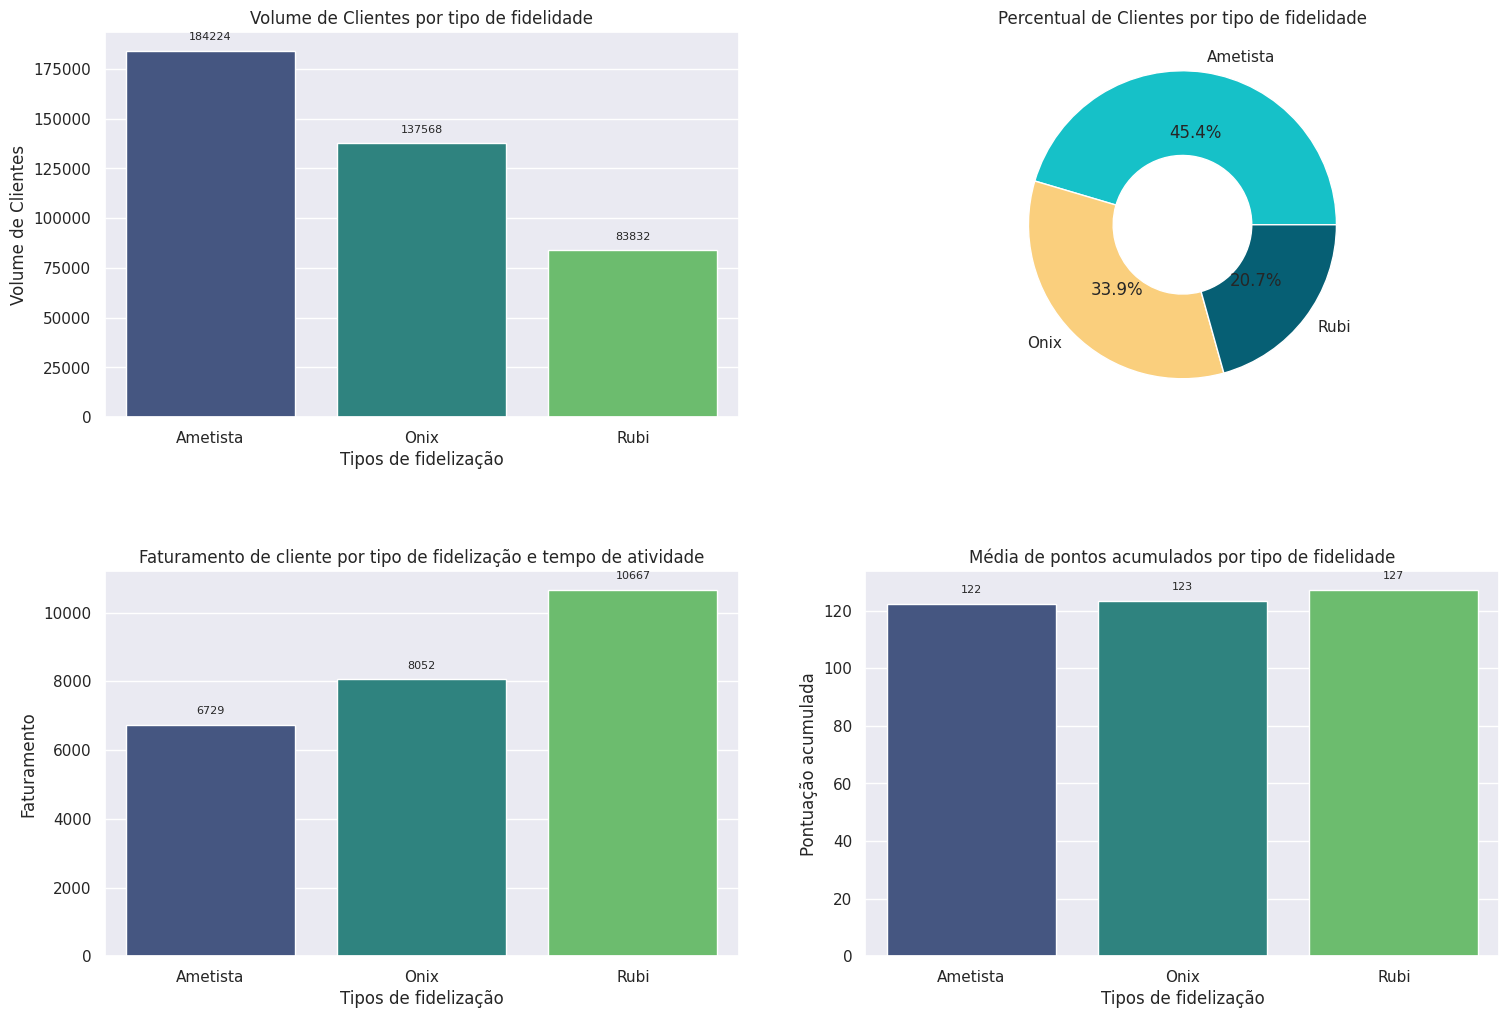

In [38]:
colors = ["#16c1c8", "#facf7d", "#065f74"]

plt.figure(figsize=(18, 12))
plt.subplot(2, 2, 1)
aux = df4[['loyalty_number', 'loyalty_card']].groupby('loyalty_card').count().reset_index()
barplot = sns.barplot(data = aux, x = 'loyalty_card', y = 'loyalty_number', hue = 'loyalty_card', palette='viridis')
plt.title('Volume de Clientes por tipo de fidelidade')
plt.xlabel('Tipos de fidelização')
plt.ylabel('Volume de Clientes')

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.subplot(2, 2, 2)
aux1 = df4[['loyalty_card', 'loyalty_number']].groupby('loyalty_card').count().reset_index()
plt.pie(aux1['loyalty_number'], labels = aux1['loyalty_card'], autopct='%1.1f%%', wedgeprops=dict(width=0.55), colors = colors)
plt.title('Percentual de Clientes por tipo de fidelidade')

plt.subplot(2, 2, 3)
aux2 = df4[['clv', 'loyalty_card']].groupby('loyalty_card').mean().reset_index()
barplot1 = sns.barplot(data = aux2, x = 'loyalty_card', y = 'clv', hue = 'loyalty_card', palette='viridis')
plt.title('Faturamento de cliente por tipo de fidelização e tempo de atividade')
plt.xlabel('Tipos de fidelização')
plt.ylabel('Faturamento')

for p in barplot1.patches:
    barplot1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.subplot(2, 2, 4)
aux3 = df4[['points_accumulated', 'loyalty_card']].groupby('loyalty_card').mean().reset_index()
barplot2 = sns.barplot(data = aux3, x = 'loyalty_card', y = 'points_accumulated', hue = 'loyalty_card', palette='viridis')
plt.title('Média de pontos acumulados por tipo de fidelidade')
plt.xlabel('Tipos de fidelização')
plt.ylabel('Pontuação acumulada')

for p in barplot2.patches:
    barplot2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.subplots_adjust(hspace=0.4)

plt.show()

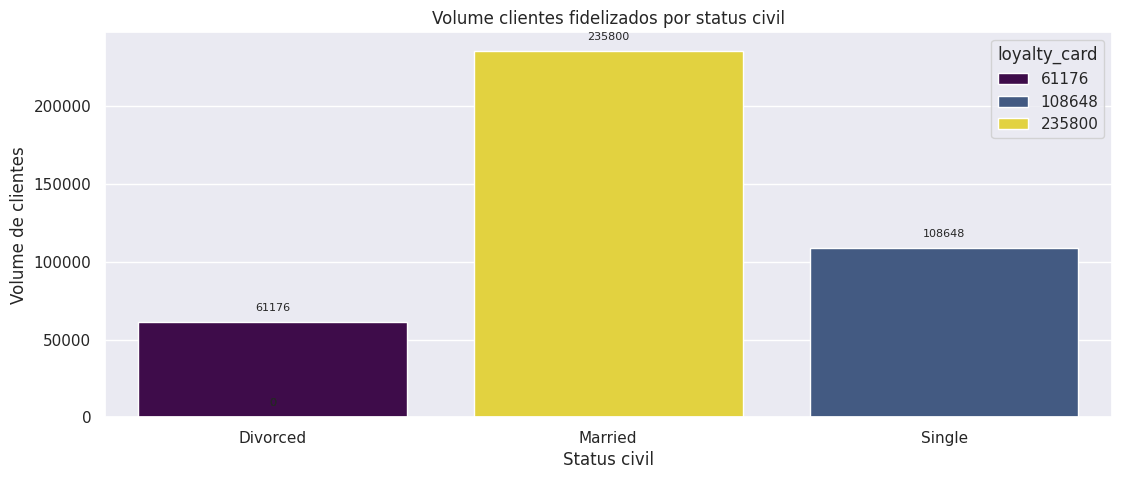

In [39]:
aux3 = df4[['marital_status', 'loyalty_card', 'loyalty_number']].groupby('marital_status').count().reset_index()
barplot2 = sns.barplot(data = aux3, x = 'marital_status', y = 'loyalty_number', hue = 'loyalty_card', palette='viridis')
plt.title('Volume clientes fidelizados por status civil')
plt.xlabel('Status civil')
plt.ylabel('Volume de clientes')

for p in barplot2.patches:
    barplot2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.subplots_adjust(hspace=0.4)

plt.show()

### 4.2.2 - Pontuação acumulada por cidade e provincia

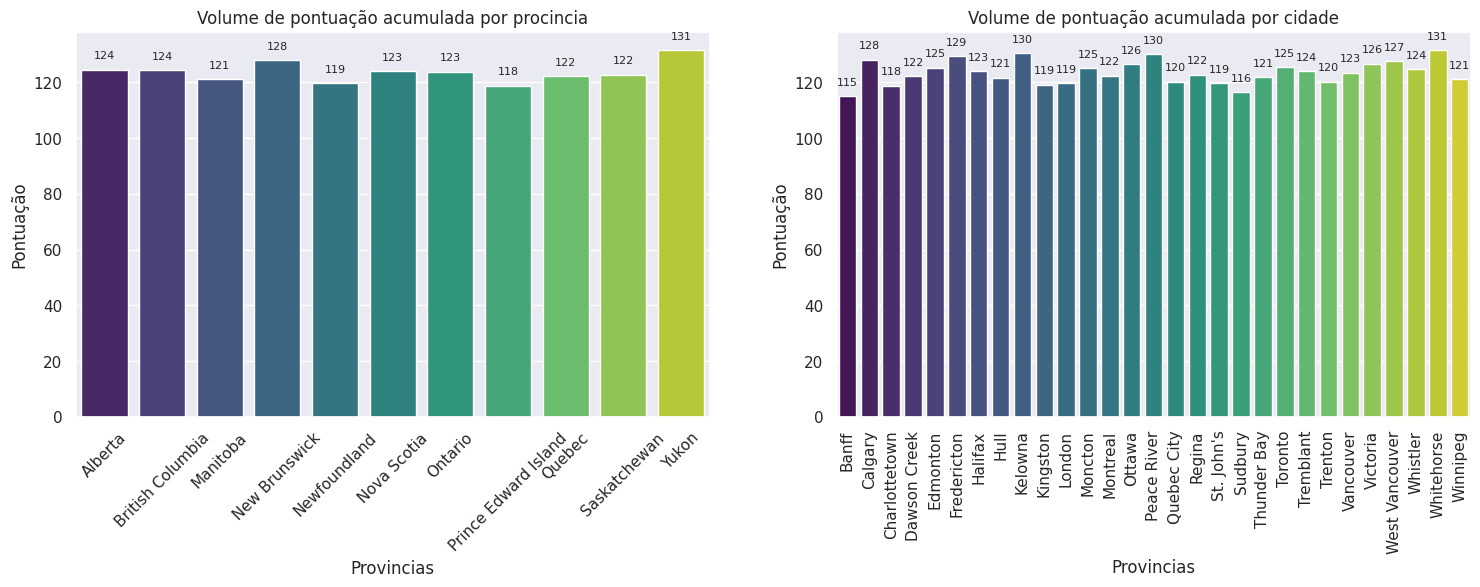

In [40]:

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
aux = df4[['province', 'points_accumulated']].groupby('province').mean().reset_index()
barplot = sns.barplot(data = aux, x = 'province', y = 'points_accumulated', palette='viridis')
plt.title('Volume de pontuação acumulada por procincia')
plt.xlabel('Provincias')
plt.ylabel('Pontuação')
plt.xticks(rotation = 45)

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.subplot(1, 2, 2)
aux = df4[['city', 'points_accumulated']].groupby('city').mean().reset_index()
barplot4 = sns.barplot(data = aux, x = 'city', y = 'points_accumulated', palette='viridis')
plt.title('Volume de pontuação acumulada por cidade')
plt.xlabel('Provincias')
plt.ylabel('Pontuação')
plt.xticks(rotation = 90)

for p in barplot4.patches:
    barplot4.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()

### 4.2.3 - Correlação Estatistica entre fetaures

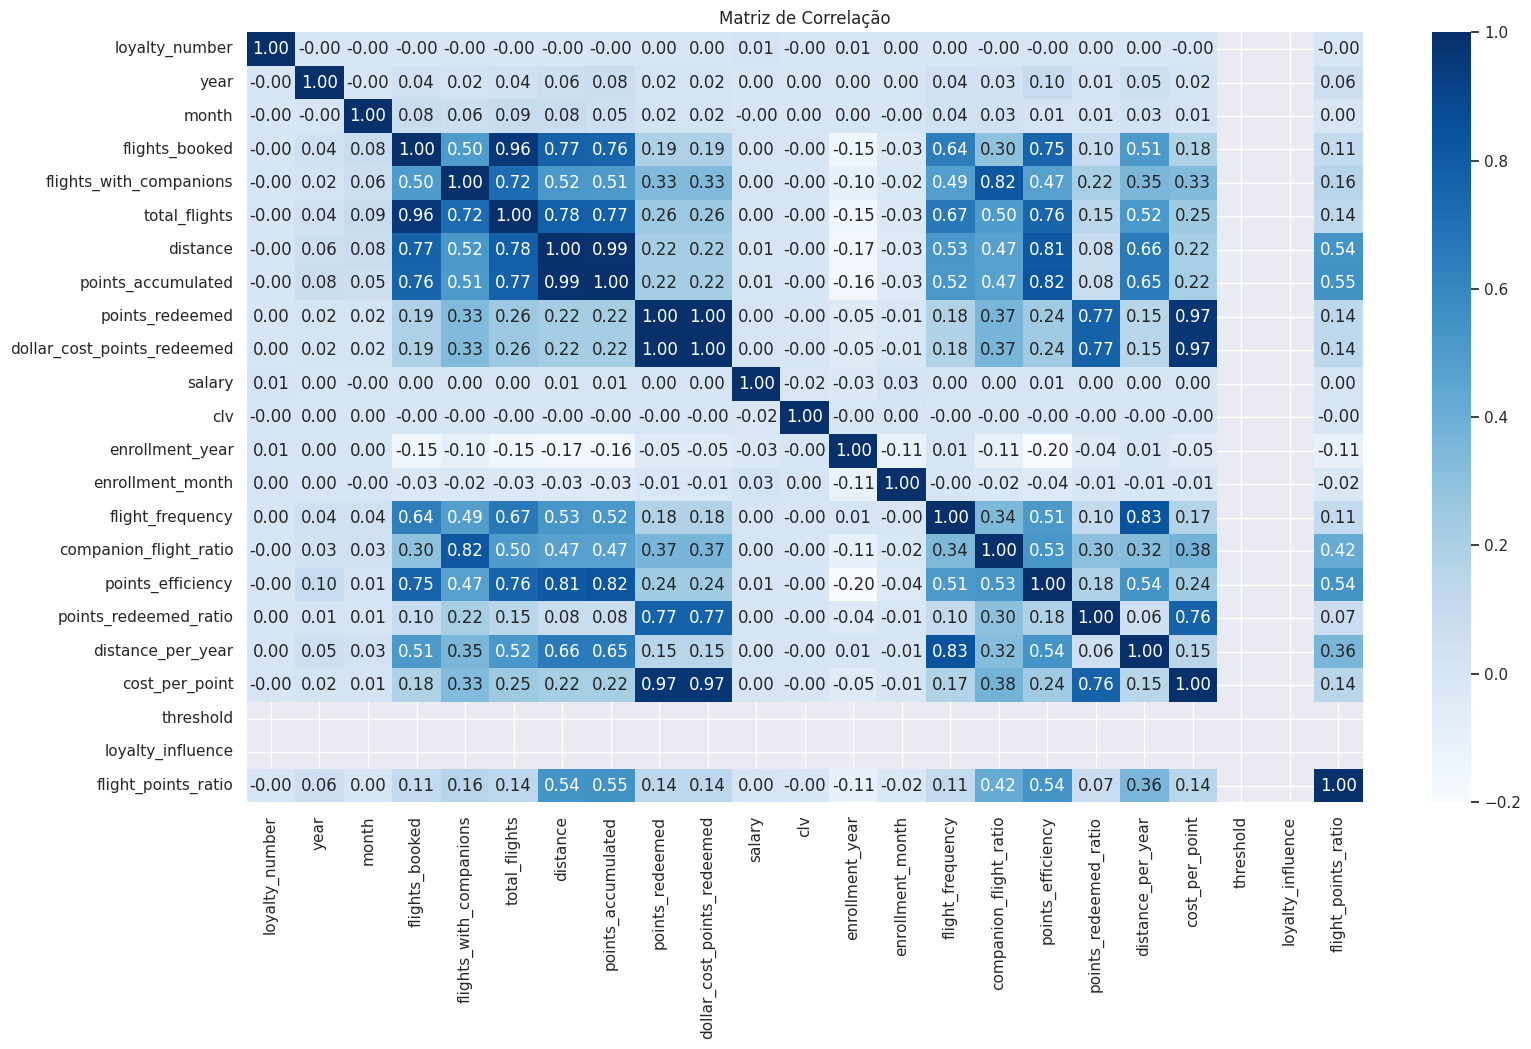

In [41]:
# Matriz de correlação
df_numeric = df4.select_dtypes(include=['int', 'float'])
plt.figure(figsize=(18, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Matriz de Correlação")
plt.show()

## 4.3 - MULTIVARIATE ANALYSIS

### Qual é a correlação entre o número de voos (flights_booked) e a acumulação de pontos (points_accumulated)?

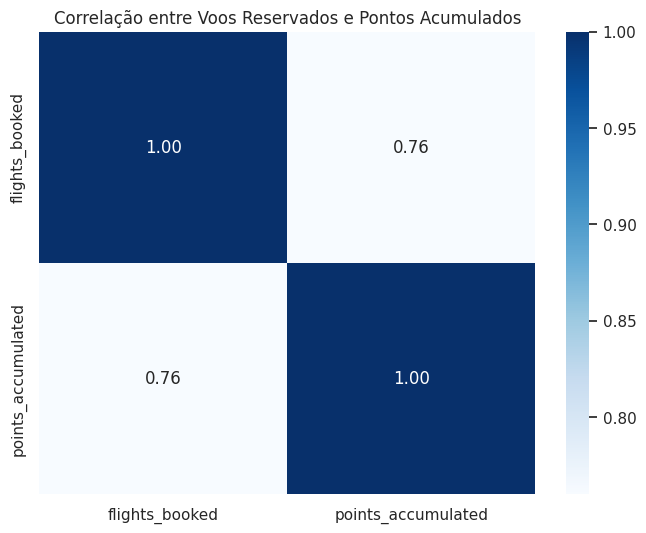

Coeficiente de correlação: 0.76
Valor-p: 0.0000


In [42]:
corr = df4[['flights_booked', 'points_accumulated']].corr()

# Exibe o mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlação entre Voos Reservados e Pontos Acumulados')
plt.show()

correlation, p_value = pearsonr(df4['flights_booked'], df4['points_accumulated'])
print(f"Coeficiente de correlação: {correlation:.2f}")
print(f"Valor-p: {p_value:.4f}")



### Clientes com maior número de voos acompanhados por terceiros (flights_with_companions) são mais leais ao programa?


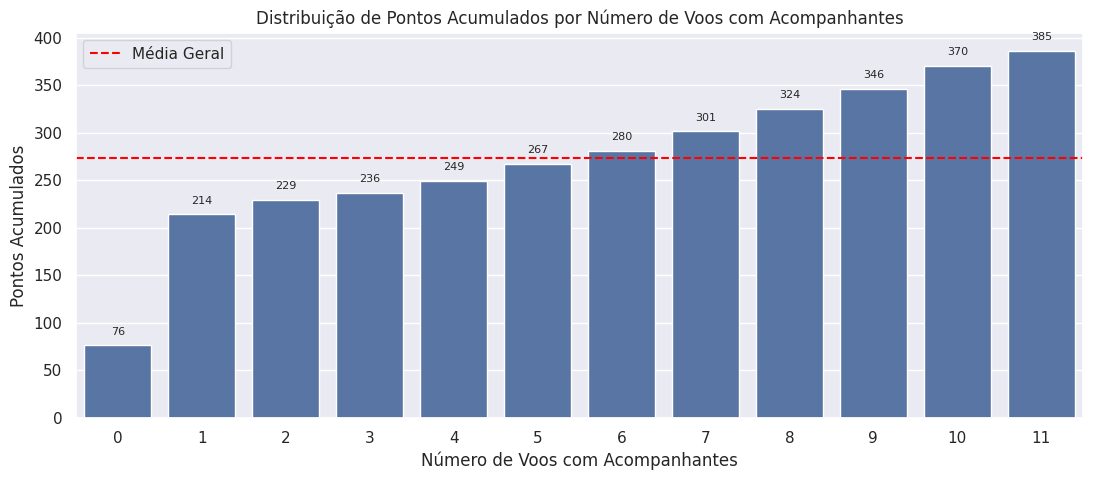

Coeficiente de correlação: 0.51
Valor-p: 0.0000


In [43]:
aux = df4[['flights_with_companions', 'points_accumulated']].groupby('flights_with_companions').mean().reset_index()
barplot = sns.barplot(data = aux, x = 'flights_with_companions', y = 'points_accumulated')
plt.title('Distribuição de Pontos Acumulados por Número de Voos com Acompanhantes')
plt.xlabel('Número de Voos com Acompanhantes')
plt.ylabel('Pontos Acumulados')

mean_value = aux['points_accumulated'].mean()  # Calculando a média geral
plt.axhline(mean_value, color='red', linestyle='--', label='Média Geral')  # Linha tracejada
plt.legend()

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
plt.show()

correlation, p_value = pearsonr(df4['flights_with_companions'], df4['points_accumulated'])
print(f"Coeficiente de correlação: {correlation:.2f}")
print(f"Valor-p: {p_value:.4f}")

### Qual é a tendência de retenção de clientes baseada na points_redeemed (pontos resgatados)?

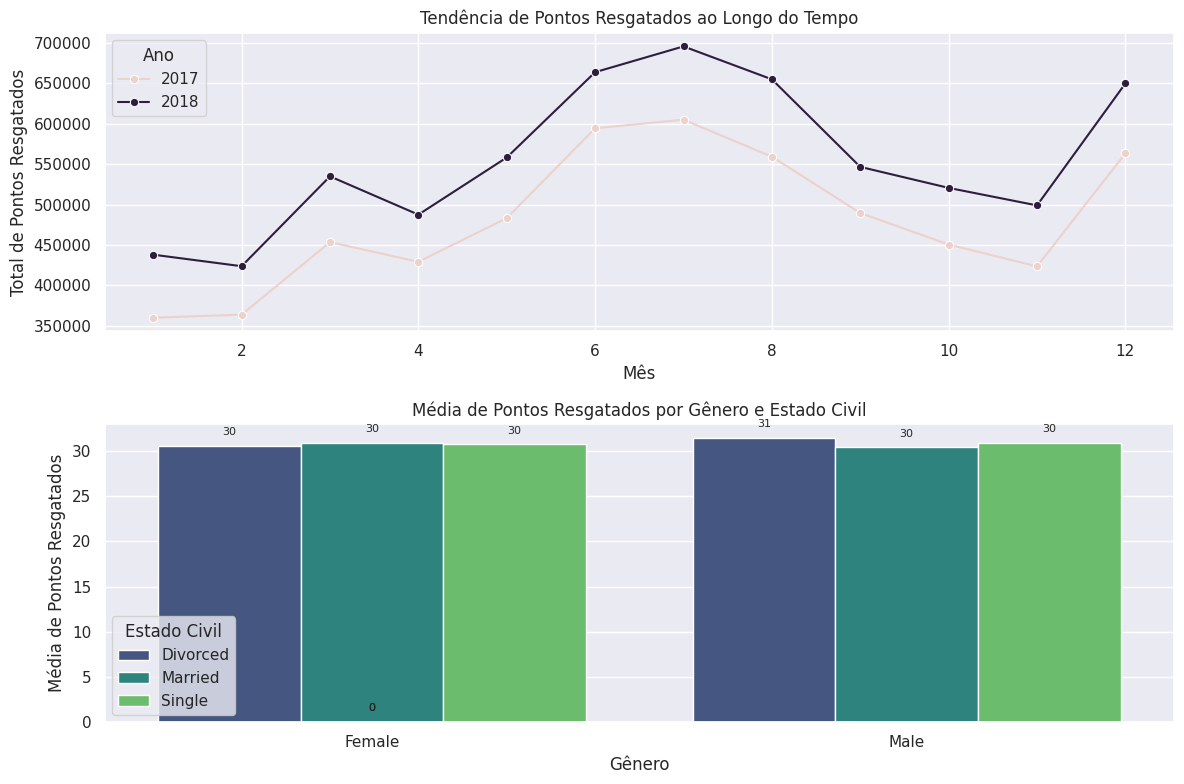

In [44]:
# Agrupar os dados por ano e mês para calcular a soma dos pontos resgatados
monthly_redeemed = df4.groupby(['year', 'month'])['points_redeemed'].sum().reset_index()

# Criar um gráfico de linha
plt.figure(figsize=(12, 8))
plt.subplot(2,1,1)
sns.lineplot(data=monthly_redeemed, x='month', y='points_redeemed', hue='year', marker='o')
plt.title('Tendência de Pontos Resgatados ao Longo do Tempo')
plt.xlabel('Mês')
plt.ylabel('Total de Pontos Resgatados')
plt.legend(title='Ano')

# Exemplo de análise da retenção com base no gênero
# Calcular a média de pontos resgatados por gênero e estado civil
avg_redeemed_gender = df4.groupby(['gender', 'marital_status'])['points_redeemed'].mean().reset_index()

# Criar o gráfico de barras
plt.subplot(2,1,2)
barplot = sns.barplot(data=avg_redeemed_gender, x='gender', y='points_redeemed', hue='marital_status', palette='viridis')
plt.title('Média de Pontos Resgatados por Gênero e Estado Civil')
plt.xlabel('Gênero')
plt.ylabel('Média de Pontos Resgatados')
plt.legend(title='Estado Civil')
plt.subplots_adjust(hspace=0.9)

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
    
plt.tight_layout()
plt.show()

### Qual é a relação entre a frequência de voos (total de voos, voos acompanhados) e o valor do tempo de vida do cliente (CLV)?

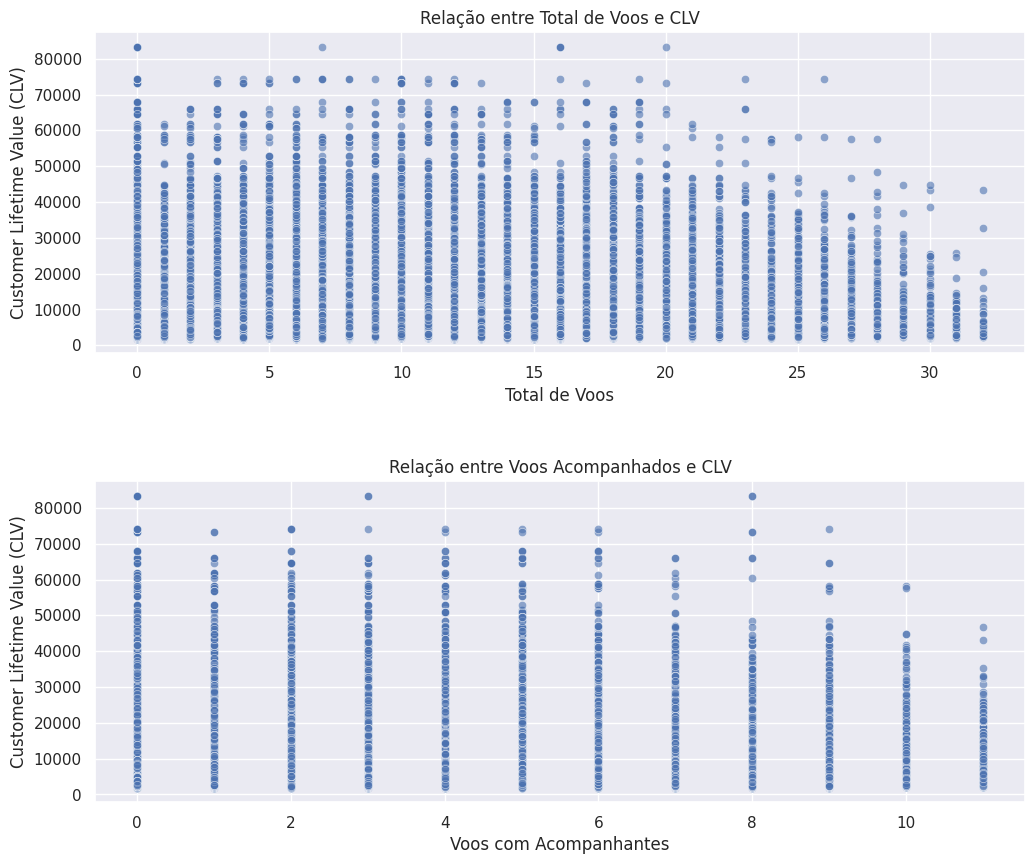

In [45]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
sns.scatterplot(data=df4, x='total_flights', y='clv', alpha=0.6)
plt.title('Relação entre Total de Voos e CLV')
plt.xlabel('Total de Voos')
plt.ylabel('Customer Lifetime Value (CLV)')

plt.subplot(2,1,2)
sns.scatterplot(data=df4, x='flights_with_companions', y='clv', alpha=0.6)
plt.title('Relação entre Voos Acompanhados e CLV')
plt.xlabel('Voos com Acompanhantes')
plt.ylabel('Customer Lifetime Value (CLV)')
plt.subplots_adjust(hspace=0.4)


plt.show()


### Qual é o impacto do tipo de cartão de fidelidade (Rubi, Ônix, Ametista) na lealdade do cliente, medido pelo CLV?

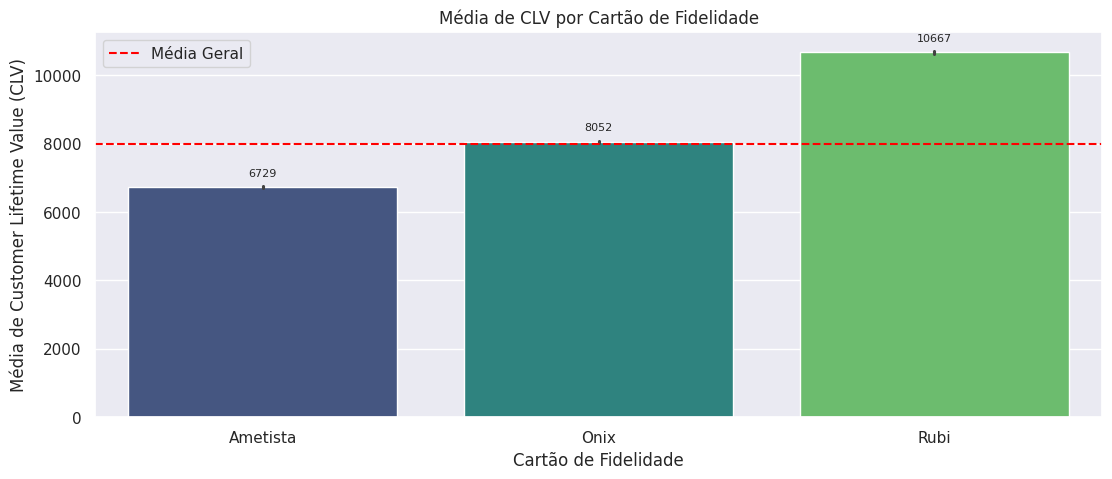

In [46]:
df_aux = df4.copy()
df_aux['loyalty_card'] = df_aux['loyalty_card'].replace({'Rubi': 3, 'Onix': 2, 'Ametista':1}).astype(int)
aux = df_aux[['clv', 'loyalty_card']].groupby('loyalty_card').mean().reset_index()
barplot = sns.barplot(data = df_aux, x = 'loyalty_card', y = 'clv', palette='viridis')

mean_value = df_aux['clv'].mean()  # Calculando a média geral
plt.axhline(mean_value, color='red', linestyle='--', label='Média Geral')  # Linha tracejada

card_labels = {1: 'Ametista', 2: 'Onix', 3: 'Rubi'}
plt.xticks(ticks=[0, 1, 2], labels=[card_labels[1], card_labels[2], card_labels[3]])
plt.title('Média de CLV por Cartão de Fidelidade')
plt.xlabel('Cartão de Fidelidade')
plt.ylabel('Média de Customer Lifetime Value (CLV)')
plt.legend()

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
    
plt.show()

### Como a distância total voada se relaciona com a quantidade de voos reservados e os pontos acumulados?

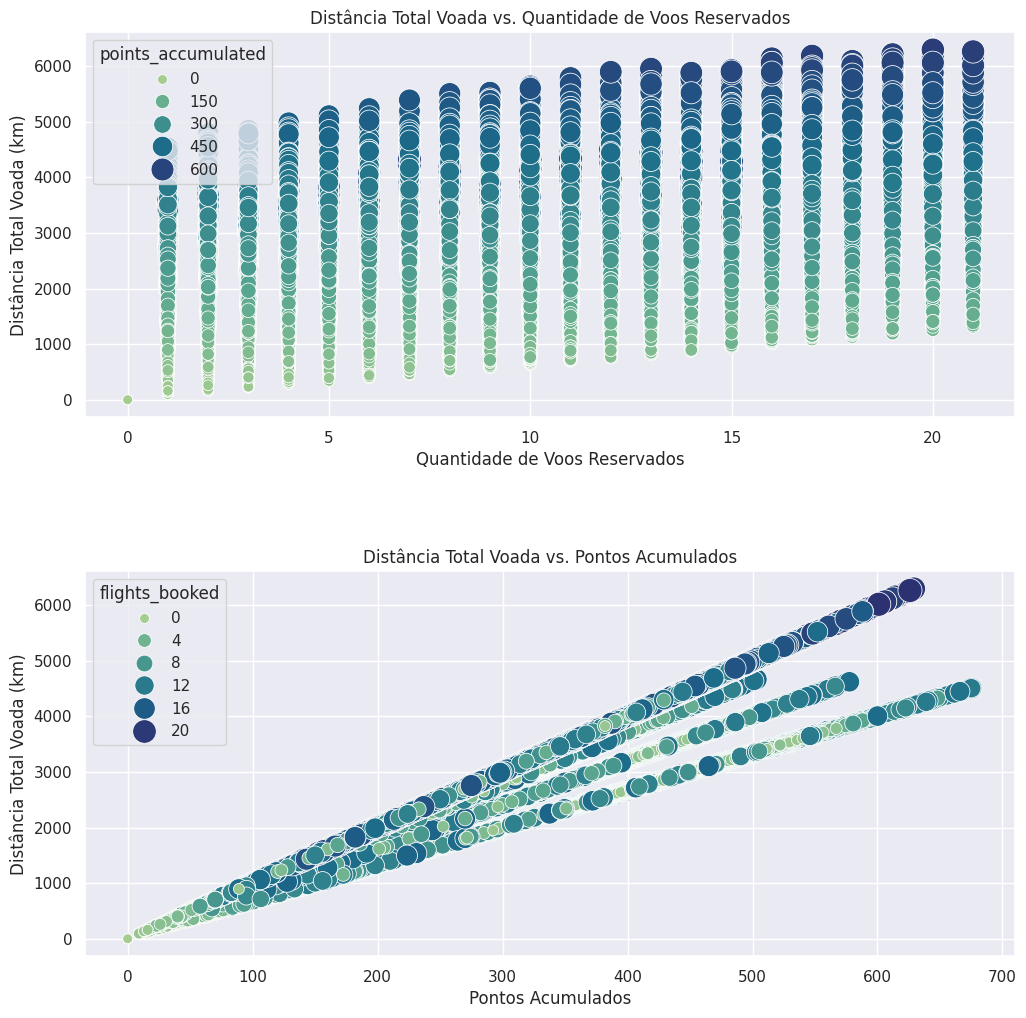

In [47]:
plt.figure(figsize=(12, 12))

# Gráfico 1: Distância total voada vs. Quantidade de voos reservados
plt.subplot(2, 1, 1)
sns.scatterplot(data=df4, x='flights_booked', y='distance', hue='points_accumulated', size='points_accumulated', sizes=(50, 300), palette='crest')
plt.title('Distância Total Voada vs. Quantidade de Voos Reservados')
plt.xlabel('Quantidade de Voos Reservados')
plt.ylabel('Distância Total Voada (km)')


# Gráfico 2: Distância total voada vs. Pontos Acumulados
plt.subplot(2, 1, 2)
sns.scatterplot(data=df4, x='points_accumulated', y='distance', hue='flights_booked', size='flights_booked', sizes=(50, 300), palette='crest')
plt.title('Distância Total Voada vs. Pontos Acumulados')
plt.xlabel('Pontos Acumulados')
plt.ylabel('Distância Total Voada (km)')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [48]:
# Calcular a correlação
correlation_booked_distance = df4['flights_booked'].corr(df4['distance'])
correlation_points_distance = df4['points_accumulated'].corr(df4['distance'])

print(f"Correlação entre voos reservados e distância total voada: {correlation_booked_distance:.2f}")
print(f"Correlação entre pontos acumulados e distância total voada: {correlation_points_distance:.2f}")


Correlação entre voos reservados e distância total voada: 0.77
Correlação entre pontos acumulados e distância total voada: 0.99


### Qual é a tendência de pontos acumulados ao longo do tempo, considerando diferentes tipos de cartões de fidelidade?



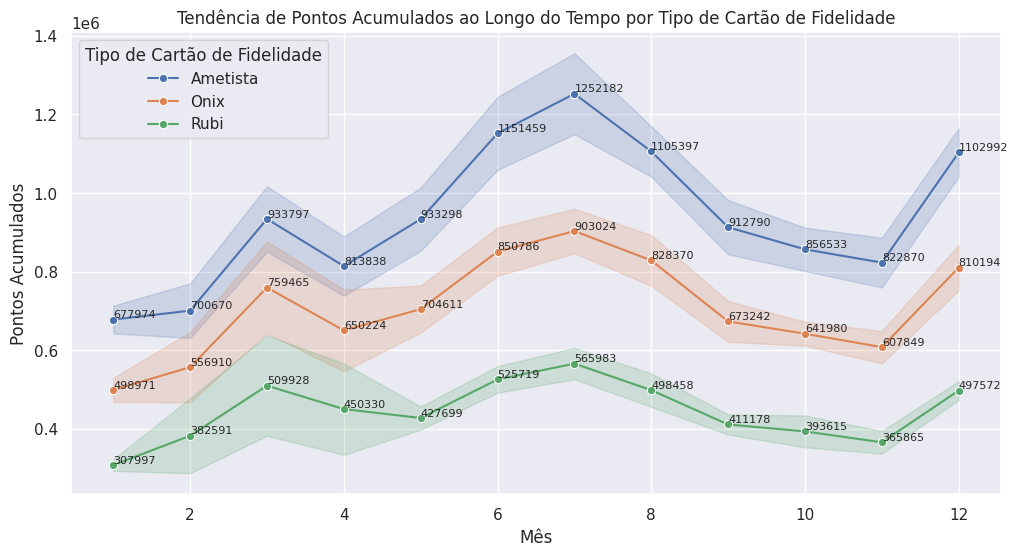

In [49]:
# Exemplo de agrupamento dos dados
df_aux = df4.copy()
monthly_points = df_aux.groupby(['year', 'month', 'loyalty_card'])['points_accumulated'].sum().reset_index()


plt.figure(figsize=(12, 6))

# Criar o gráfico de linha
plot = sns.lineplot(data=monthly_points, x='month', y='points_accumulated', hue='loyalty_card', marker='o')

# Configurar o título e os rótulos
plt.title('Tendência de Pontos Acumulados ao Longo do Tempo por Tipo de Cartão de Fidelidade')
plt.xlabel('Mês')
plt.ylabel('Pontos Acumulados')
plt.legend(title='Tipo de Cartão de Fidelidade')

for line in plot.lines:
    y_data = line.get_ydata()
    x_data = line.get_xdata()
    for x, y in zip(x_data, y_data):
        plt.text(x, y, f'{int(y)}', ha='left', va='bottom', fontsize=8)

# Mostrar o gráfico
plt.show()


### Como o salario e o estado civil dos clientes influenciam a frequência de viagens e a acumulação de pontos?




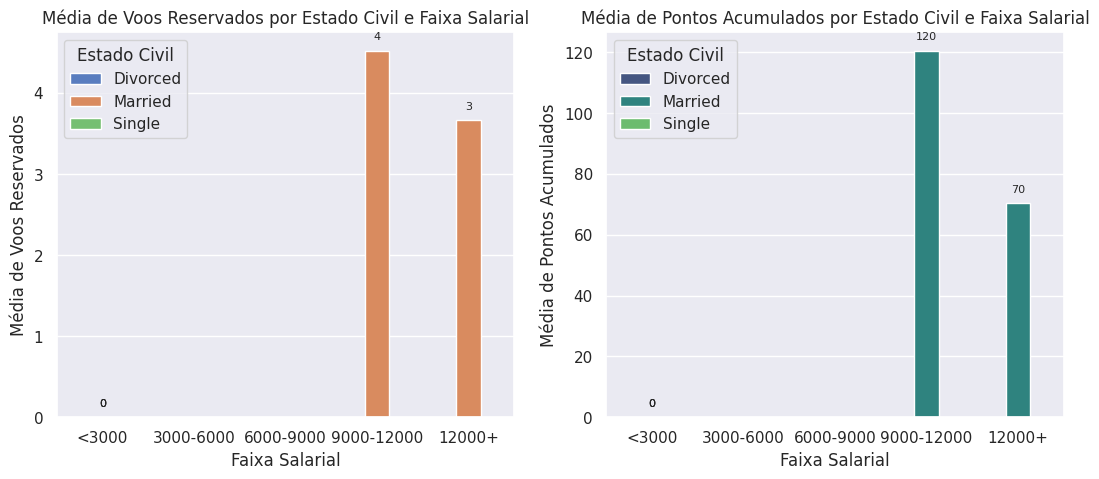

Correlação entre Salário e Total de Voos: 0.00
Correlação entre Salário e Pontos Acumulados: 0.01


In [50]:
# Calcular a média de voos e pontos por estado civil e faixa salarial
salary_bins = pd.cut(df4['salary'], bins=[0, 3000, 6000, 9000, 12000, 15000], labels=['<3000', '3000-6000', '6000-9000', '9000-12000', '12000+'])
df4['salary_group'] = salary_bins

avg_flights_points = df4.groupby(['marital_status', 'salary_group']).agg(
    total_flights=('total_flights', 'mean'),
    points_accumulated=('points_accumulated', 'mean')
).reset_index()

plt.subplot(1,2,1)
barplot = sns.barplot(data=avg_flights_points, x='salary_group', y='total_flights', hue='marital_status', palette='muted')
plt.title('Média de Voos Reservados por Estado Civil e Faixa Salarial')
plt.xlabel('Faixa Salarial')
plt.ylabel('Média de Voos Reservados')
plt.legend(title='Estado Civil')

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)


plt.subplot(1,2,2)
barplot2 = sns.barplot(data=avg_flights_points, x='salary_group', y='points_accumulated', hue='marital_status', palette='viridis')
plt.title('Média de Pontos Acumulados por Estado Civil e Faixa Salarial')
plt.xlabel('Faixa Salarial')
plt.ylabel('Média de Pontos Acumulados')
plt.legend(title='Estado Civil')

for p in barplot2.patches:
    barplot2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()

correlation_flights = df4['salary'].corr(df4['total_flights'])
correlation_points = df4['salary'].corr(df4['points_accumulated'])

print(f"Correlação entre Salário e Total de Voos: {correlation_flights:.2f}")
print(f"Correlação entre Salário e Pontos Acumulados: {correlation_points:.2f}")



### Como o custo por ponto e a eficiência de pontos impactam o total de pontos acumulados e resgatados por diferentes grupos de clientes?


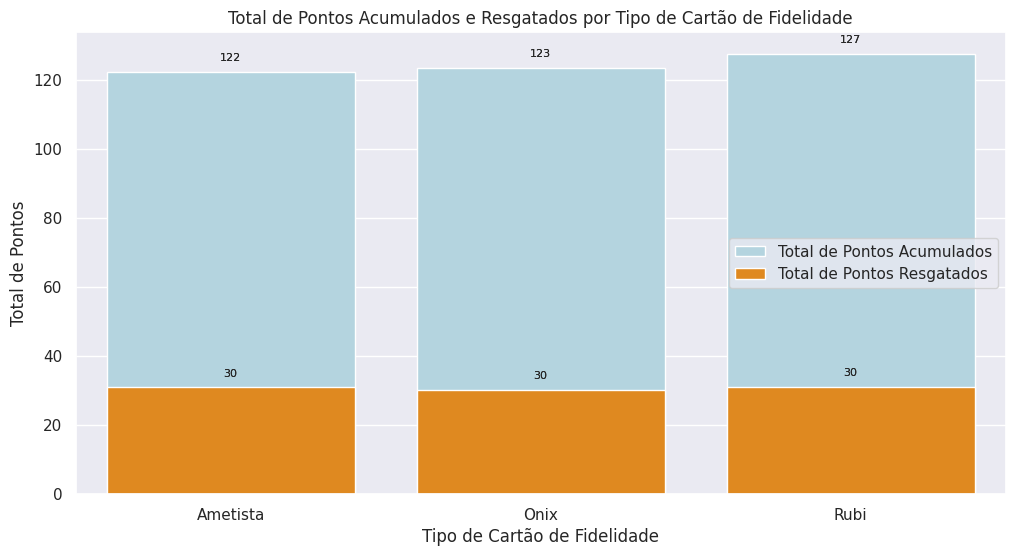

In [51]:
# Agrupar os dados por tipo de cartão de fidelidade
metrics = df4.groupby('loyalty_card').agg(
    total_points_accumulated=('points_accumulated', 'mean'),
    total_points_redeemed=('points_redeemed', 'mean'),
    cost_per_point=('cost_per_point', 'mean'),
    points_efficiency=('points_efficiency', 'mean')
).reset_index()

plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=metrics, x='loyalty_card', y='total_points_accumulated', color='lightblue', label='Total de Pontos Acumulados')
barplot2 = sns.barplot(data=metrics, x='loyalty_card', y='total_points_redeemed', color='darkorange', label='Total de Pontos Resgatados')
plt.title('Total de Pontos Acumulados e Resgatados por Tipo de Cartão de Fidelidade')
plt.xlabel('Tipo de Cartão de Fidelidade')
plt.ylabel('Total de Pontos')
plt.legend()

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
    
for p in barplot2.patches:
    barplot2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)

plt.show()


In [52]:
correlation_matrix = df4[['points_accumulated', 'points_redeemed', 'cost_per_point', 'points_efficiency']].corr()
correlation_matrix

,points_accumulated,points_redeemed,cost_per_point,points_efficiency
points_accumulated,1.000000,0.223230,0.220690,0.823813
points_redeemed,0.223230,1.000000,0.970855,0.235786
cost_per_point,0.220690,0.970855,1.000000,0.244001
points_efficiency,0.823813,0.235786,0.244001,1.000000


### Qual é a distribuição de pontos acumulados e resgatados entre diferentes regiões (país, província, cidade)?


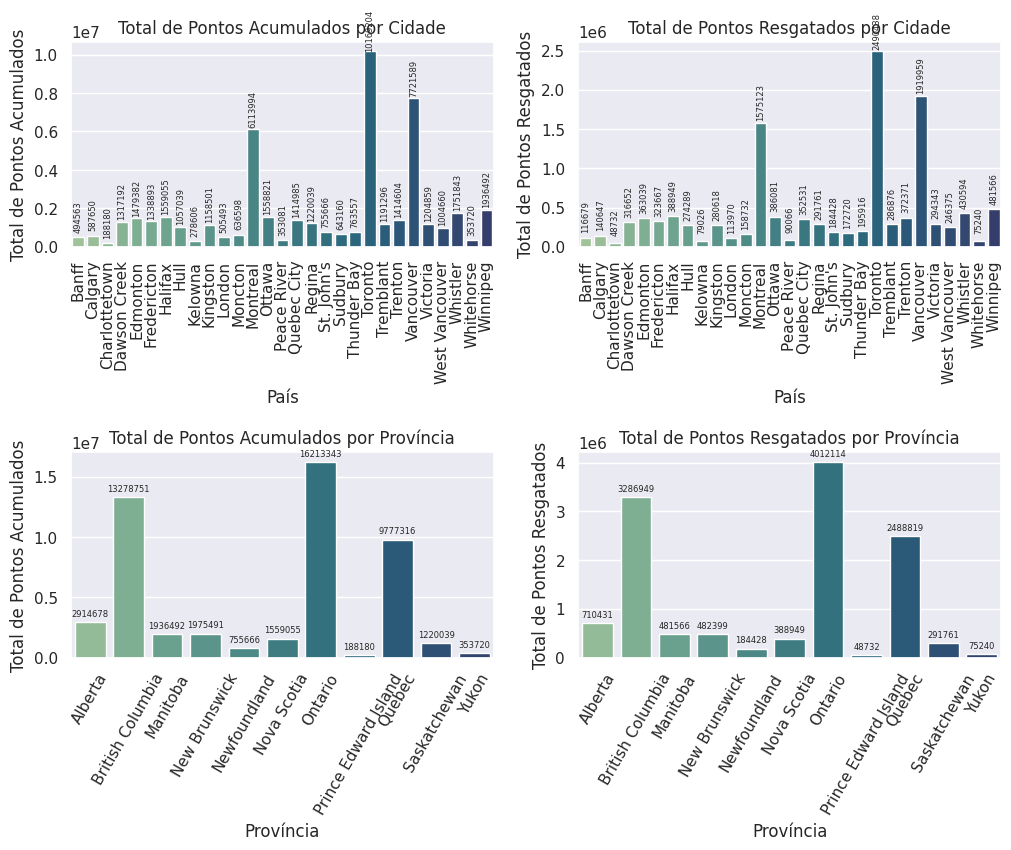

In [53]:
# Agrupar dados por província
points_by_province = df4.groupby('province').agg(
    total_points_accumulated=('points_accumulated', 'sum'),
    total_points_redeemed=('points_redeemed', 'sum')
).reset_index()

# Agrupar dados por cidade
points_by_city = df4.groupby('city').agg(
    total_points_accumulated=('points_accumulated', 'sum'),
    total_points_redeemed=('points_redeemed', 'sum')
).reset_index()

plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
barplot = sns.barplot(data=points_by_city, x='city', y='total_points_accumulated', palette='crest')
plt.title('Total de Pontos Acumulados por Cidade')
plt.xlabel('País')
plt.ylabel('Total de Pontos Acumulados')
plt.xticks(rotation=90)

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', rotation='vertical', va='center', xytext=(0, 15), textcoords='offset points', fontsize=6)

plt.subplot(2,2,2)
barplot2 = sns.barplot(data=points_by_city, x='city', y='total_points_redeemed', palette='crest')
plt.title('Total de Pontos Resgatados por Cidade')
plt.xlabel('País')
plt.ylabel('Total de Pontos Resgatados')
plt.xticks(rotation=90)

for p in barplot2.patches:
    barplot2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', rotation='vertical', va='center', xytext=(0, 15), textcoords='offset points', fontsize=6)

plt.subplot(2,2,3)
barplot3 = sns.barplot(data=points_by_province, x='province', y='total_points_accumulated', palette='crest')
plt.title('Total de Pontos Acumulados por Província')
plt.xlabel('Província')
plt.ylabel('Total de Pontos Acumulados')
plt.xticks(rotation=60)

for p in barplot3.patches:
    barplot3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=6)

plt.subplot(2,2,4)
barplot4 = sns.barplot(data=points_by_province, x='province', y='total_points_redeemed', palette='crest')
plt.title('Total de Pontos Resgatados por Província')
plt.xlabel('Província')
plt.ylabel('Total de Pontos Resgatados')
plt.xticks(rotation=60)

for p in barplot4.patches:
    barplot4.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=6)

plt.subplots_adjust(hspace=1)
plt.show()


# 5.0 - DATA PREPARATION

In [54]:
df5 = df4.copy()
df5.to_csv('../data/flight_.csv', index=False)

## 5.1 - FEATURE SELECTION

In [55]:
feature_selected = ['year', 'month', 'flights_booked','flights_with_companions', 'total_flights','distance', 
'points_accumulated', 'salary','clv', 'loyalty_card','enrollment_type', 'marital_status']

df5 = df5[feature_selected]

## 5.2 - DATA ENCODER

### 5.2.1 - MINMAX SCALER

In [56]:
# Codificação para a coluna loyalty_card
list_encoder = {'Ametista': 1, 'Onix': 2, 'Rubi': 3}
df5['loyalty_card'] = df5['loyalty_card'].map(list_encoder).astype(int)
with open('../model/encoder/loyalty_card_encoded.pkl', 'wb') as file:
    pickle.dump(df5['loyalty_card'], file)

# Codificação para a coluna enrollment_type
list_enrollment_type = {'Standard': 1, '2018 Promotion': 2}
df5['enrollment_type'] = df5['enrollment_type'].map(list_enrollment_type).astype(int)
with open('../model/encoder/enrollment_type_encoded.pkl', 'wb') as file:
    pickle.dump(df5['enrollment_type'], file)

# Codificação para a coluna marital_status
list_marital_status = {'Divorced': 1, 'Single': 2, 'Married': 3}
df5['marital_status'] = df5['marital_status'].map(list_marital_status).astype(int)
with open('../model/encoder/marital_status_encoded.pkl', 'wb') as file:
    pickle.dump(df5['marital_status'], file)

# Inicializando os scalers
std = StandardScaler()
mms = MinMaxScaler()

# Aplicando o MinMaxScaler para as outras colunas
for col in ['year', 'month', 'flights_booked', 'flights_with_companions', 'total_flights', 'distance', 'points_accumulated']:
    df5[col] = mms.fit_transform(df5[[col]])
    with open(f'../model/encoder/{col}_scaler.pkl', 'wb') as file:
        pickle.dump(mms, file)

for col in ['salary', 'clv']:
    df5[col] = std.fit_transform(df5[[col]])
    with open(f'../model/encoder/{col}_scaler.pkl', 'wb') as file:
        pickle.dump(std, file)

### 5.2.2 - STANDARD SCALER

### 5.2.3 - ORDINAL ENCODER

# 6.0 - MACHINE LEARNING MODEL

In [57]:
df6 = df5.copy()

## 6.1 - SPLIT TRAIN TEST DATA

In [58]:
x = df6.drop(columns = ['loyalty_card'])
y = df6.loc[:, 'loyalty_card'].astype(int)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## 6.2 - HYPER PARAMETER FINETUNNING

### 6.2.1 - DECISION TREE

In [59]:
param_grid_dt = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16], 'min_samples_split': [2, 5, 10]}
grid_search_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5, scoring='accuracy')

# Treinar o modelo
grid_search_dt.fit(x_train, y_train)

# Melhor modelo após ajuste de hiperparâmetros
best_model_dt = grid_search_dt.best_estimator_

### 6.2.2 - KNN (KNEARST-NEIGHBORS)

In [60]:
param_grid_knn = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
grid_search_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')

# Treinar o modelo
grid_search_knn.fit(x_train, y_train)

# Melhor modelo após ajuste de hiperparâmetros
best_model_knn = grid_search_knn.best_estimator_

### 6.2.3 - LOGISTIC REGRESSION

In [61]:
# Definir o GridSearchCV para Logistic Regression
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'solver': ['liblinear', 'saga']}
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')

# Treinar o modelo
grid_search_lr.fit(x_train, y_train)

# Melhor modelo após ajuste de hiperparâmetros
best_model_lr = grid_search_lr.best_estimator_


## 6.3 - CROSS-VALIDATION

In [62]:
def avaliar_modelo(model, x_test, y_test):
    y_pred = model.predict(x_test)
    acuracia = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precisao = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Acurácia: {acuracia:.2f}, F1 Score: {f1:.2f}, Precisão: {precisao:.2f}, Recall: {recall:.2f}")

# Avaliar cada modelo
print("Avaliação do Decision Tree:")
avaliar_modelo(best_model_dt, x_test, y_test)

print("\nAvaliação do KNN:")
avaliar_modelo(best_model_knn, x_test, y_test)

print("\nAvaliação do Logistic Regression:")
avaliar_modelo(best_model_lr, x_test, y_test)

Avaliação do Decision Tree:
Acurácia: 0.57, F1 Score: 0.55, Precisão: 0.62, Recall: 0.57

Avaliação do KNN:
Acurácia: 0.50, F1 Score: 0.49, Precisão: 0.49, Recall: 0.50

Avaliação do Logistic Regression:
Acurácia: 0.47, F1 Score: 0.38, Precisão: 0.45, Recall: 0.47


## 6.4 - FINAL MODEL

In [63]:
final_model = best_model_dt.fit(x, y)

In [64]:
with open('../model/decision_tree.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [65]:
sample = x_test.sample()
y_prob = final_model.predict_proba(sample)
print('Rubi: {}%'.format(np.round(y_prob[0][0], 2)*100))
print('Onix: {}%'.format(np.round(y_prob[0][1], 2)*100))
print('Ametista: {}%'.format(np.round(y_prob[0][2], 2)*100))

Rubi: 35.0%
Onix: 33.0%
Ametista: 32.0%


### 6.4.1 - PLOT

     Classe  Probabilidade (%)
0      Rubi              34.64
1      Onix              33.48
2  Ametista              31.88


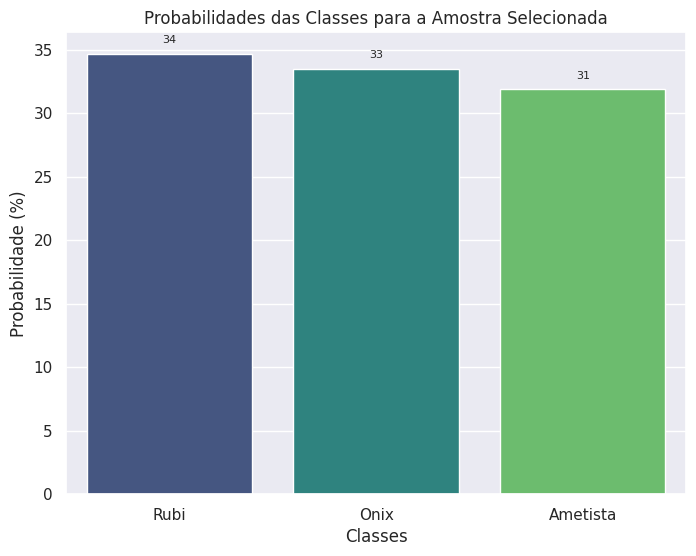

In [66]:
class_labels = ['Rubi', 'Onix', 'Ametista']
prob_df = pd.DataFrame({'Classe': class_labels, 'Probabilidade (%)': np.round(y_prob[0] * 100, 2)})

# Exibindo o DataFrame
print(prob_df)

# Plotando as probabilidades
plt.figure(figsize=(8, 6))
barplot = sns.barplot(data = prob_df, x='Classe', y='Probabilidade (%)', palette='viridis')
plt.xlabel('Classes')
plt.ylabel('Probabilidade (%)')
plt.title('Probabilidades das Classes para a Amostra Selecionada')

for p in barplot.patches:
    barplot.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=8)
plt.show()


# 7.0 - BUSINESS METRICS

#### **Relatório contendo questões de negócio:**

1 - Qual cartão de fidelidade representa o maior potencial de lucro marginal para a empresa, e como o lucro esperado se compara entre as diferentes probabilidades de compra?

In [67]:
# Definindo parâmetros financeiros
average_ticket_price = 500  # Preço médio de passagem
campaign_cost_per_customer = 10  # Custo médio da campanha
profit_margin = 0.3  # Margem de lucro estimada de 30%

# Estimando receita e lucro para cada categoria de cliente com base nas probabilidades
loyalty_labels = ['Rubi', 'Onix', 'Ametista']
for i, label in enumerate(loyalty_labels):
    purchase_prob = y_prob[0][i]  # Probabilidade de compra para a categoria
    estimated_revenue = purchase_prob * average_ticket_price * profit_margin
    estimated_profit = estimated_revenue - campaign_cost_per_customer
    print(f"{label}: Receita estimada - R${estimated_revenue:.2f}, Lucro estimado - R${estimated_profit:.2f}")

# Exibindo as probabilidades de propensão de compra
print(f'\nProbabilidades de propensão de compra:')
for i, label in enumerate(loyalty_labels):
    print(f'{label}: {np.round(y_prob[0][i] * 100, 2)}%')

Rubi: Receita estimada - R$51.96, Lucro estimado - R$41.96
Onix: Receita estimada - R$50.22, Lucro estimado - R$40.22
Ametista: Receita estimada - R$47.82, Lucro estimado - R$37.82

Probabilidades de propensão de compra:
Rubi: 34.64%
Onix: 33.48%
Ametista: 31.88%


2 - Qual o impacto estimado de receita com a conversão dos clientes, levando em consideração os três tipos de cartões?

In [68]:
# Definindo parâmetros financeiros
average_ticket_price = 500  # Preço médio de passagem
campaign_cost_per_customer = 10  # Custo médio da campanha
profit_margin = 0.3  # Margem de lucro estimada de 30%

# Inicializando variáveis de receita e lucro total
total_revenue = total_profit = 0

# Calculando lucro para todos os clientes no conjunto de teste
for _, row in x_test.iterrows():
    row_df = pd.DataFrame(row).T  # Transpondo para manter o formato correto de DataFrame
    y_prob = final_model.predict_proba(row_df)  # Probabilidades de compra

    # Calculando receita e lucro estimados para cada categoria de cliente
    for purchase_prob in y_prob[0]:  # Acessando a primeira (e única) linha
        estimated_revenue = purchase_prob * average_ticket_price * profit_margin
        estimated_profit = estimated_revenue - campaign_cost_per_customer

        # Atualizando receita e lucro totais
        total_revenue += estimated_revenue
        total_profit += estimated_profit

# Exibindo o lucro e receita totais para todos os clientes da base
print(f"Receita total estimada para todos os clientes: R${total_revenue:.2f}")
print(f"Lucro total estimado para todos os clientes: R${total_profit:.2f}")

Receita total estimada para todos os clientes: R$12168750.00
Lucro total estimado para todos os clientes: R$9735000.00


3 . Quem são os clientes com maior probabilidade de assinar cada cartão?

In [69]:
loyalty_labels = ['Rubi', 'Onix', 'Ametista']

# Obtendo as probabilidades de compra para cada cliente no conjunto de teste
probabilities = final_model.predict_proba(x_test)
df_prob = pd.DataFrame(probabilities, columns=loyalty_labels)
df_prob['customer_id'] = x_test.index  # Usando o índice do x_test como ID dos clientes

# Selecionando os clientes com maior probabilidade para cada tipo de cartão
top_customers = {}
for label in loyalty_labels:
    # Ordenando os clientes pela probabilidade de assinatura do cartão específico
    top_customers[label] = df_prob[['customer_id', label]].sort_values(by=label, ascending=False).head(10)

# Exibindo os top 10 clientes com maior probabilidade de assinar cada cartão
for label, customers in top_customers.items():
    print(f"Top 10 clientes com maior probabilidade de assinar o cartão {label}:")
    print(customers)
    print("\n")

Top 10 clientes com maior probabilidade de assinar o cartão Rubi:
       customer_id  Rubi
0           182259   1.0
51114       246950   1.0
51112        69010   1.0
51110        34534   1.0
14417       214329   1.0
14403       285392   1.0
51099       337772   1.0
51098       353087   1.0
51133       167978   1.0
51130       362852   1.0


Top 10 clientes com maior probabilidade de assinar o cartão Onix:
       customer_id  Onix
17901       180560   1.0
35973       289443   1.0
13          151481   1.0
72986       356727   1.0
72985       103980   1.0
72982       141619   1.0
31395       272542   1.0
11632       337604   1.0
11627       100126   1.0
69          328766   1.0


Top 10 clientes com maior probabilidade de assinar o cartão Ametista:
       customer_id  Ametista
81097       117621       1.0
75624       143281       1.0
75574       378241       1.0
75482       299780       1.0
75459        59028       1.0
75381       279377       1.0
1692        232319       1.0
75311       

4 . Qual é a distribuição percentual da probabilidade de assinatura para os três níveis de cartão (Ametista, Ônix, Rubi)?

In [70]:
mean_probabilities = np.mean(probabilities, axis=0)

# Definindo os labels dos cartões de fidelidade
loyalty_labels = ['Rubi', 'Onix', 'Ametista']

# Calculando a distribuição percentual
distribution_percentage = (mean_probabilities / mean_probabilities.sum()) * 100

# Exibindo a distribuição percentual para cada cartão
for label, percentage in zip(loyalty_labels, distribution_percentage):
    print(f"{label}: {percentage:.2f}%")

Rubi: 45.39%
Onix: 33.98%
Ametista: 20.62%


5 . Quais as características mais relevantes dos clientes que influenciam na decisão de assinatura?

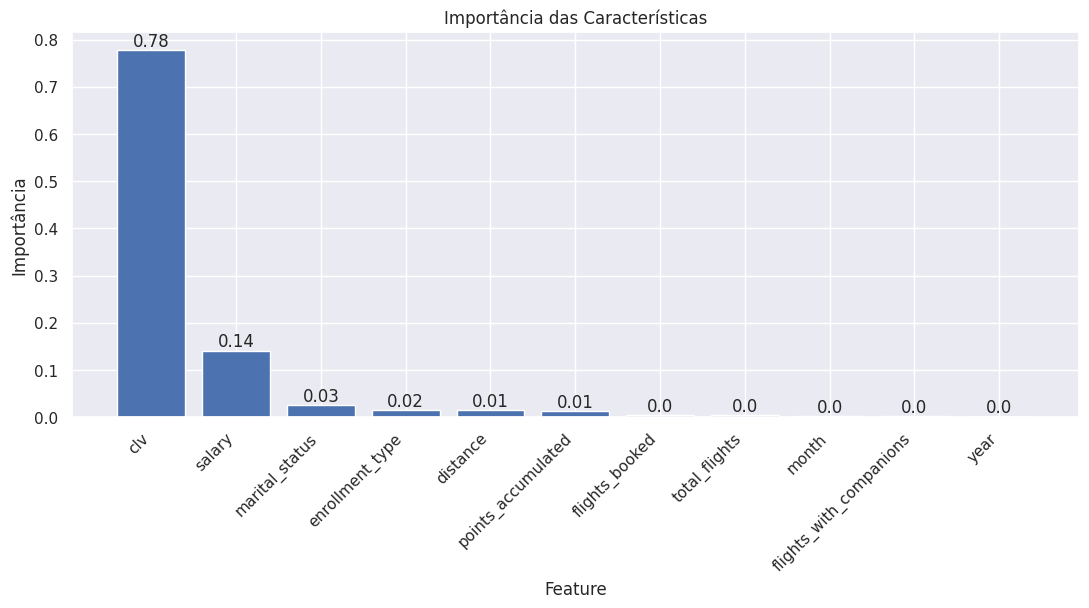

In [71]:
# Acessando a importância das features
feature_importances = final_model.feature_importances_

# Criando um DataFrame para organizar as importâncias com os nomes das features
features_df = pd.DataFrame({'Feature': x_test.columns, 'Importance': feature_importances})

# Ordenando por importância
features_df = features_df.sort_values(by='Importance', ascending=False)

bars = plt.bar(features_df['Feature'], features_df['Importance'])
plt.ylabel('Importância')
plt.xlabel('Feature')
plt.title('Importância das Características')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


6 . Quais as taxas de conversão esperadas ao utilizar as probabilidades como critério de abordagem?

In [72]:
# Calculando as taxas de conversão esperadas
conversion_rates = {
    'Rubi': np.mean(y_prob[:, 0]),
    'Onix': np.mean(y_prob[:, 1]),
    'Ametista': np.mean(y_prob[:, 2])
}

# Exibindo as taxas de conversão esperadas
for card, rate in conversion_rates.items():
    print(f"Taxa de conversão esperada para {card}: {rate * 100:.2f}%")

Taxa de conversão esperada para Rubi: 40.27%
Taxa de conversão esperada para Onix: 37.71%
Taxa de conversão esperada para Ametista: 22.02%


7 - Quais estratégias podem ser consideradas para agregar vantagens a cada plano de fidelidade (Ametista, Ônix e Rubi) e aumentar a atração e retenção de clientes?

1. Benefícios Personalizados
- Ametista: Oferecer descontos em produtos ou serviços que atraem um público mais jovem ou que está começando a fidelidade.
- Ônix: Benefícios que agradam um público intermediário, como acesso a eventos exclusivos ou promoções em viagens.
- Rubi: Oferecer serviços premium, como atendimento personalizado, upgrade de classe em voos ou acesso a salas VIP em aeroportos.

2. Acúmulo de Pontos
- Implementar um sistema de pontos onde os clientes ganham pontos por cada compra, podendo trocá-los por passagens aéreas, upgrades ou produtos exclusivos.
Aumentar a taxa de acúmulo de pontos para clientes que utilizam mais os serviços ou que atingem um determinado valor de gasto.

3. Parcerias Estratégicas
- Formar parcerias com hotéis, restaurantes e empresas de aluguel de carros para oferecer descontos ou serviços exclusivos aos membros de cada plano.
Oferecer promoções sazonais em colaboração com marcas que se alinham ao perfil do cliente.

4. Ofertas Exclusivas e Promoções
- Criar promoções exclusivas para cada plano em períodos específicos, como durante datas comemorativas ou eventos importantes.
-Oferecer ofertas em determinados dias da semana ou horários para aumentar as vendas durante períodos de baixa demanda.

5. Comunicação e Engajamento
- Desenvolver campanhas de e-mail marketing personalizadas que destacam os benefícios de cada plano e incentivam a adesão.
- Utilizar redes sociais para compartilhar histórias de sucesso de clientes que obtiveram grandes vantagens com os planos.

6. Programas de Indicação
- Criar um programa de recompensas para clientes que indicam amigos, onde tanto o cliente que indica quanto o indicado recebem benefícios, como descontos ou pontos extras.

7. Feedback e Melhoria Contínua
- Coletar feedback regularmente dos membros para entender quais benefícios são mais valorizados e ajustar os planos conforme necessário.
- Realizar pesquisas de satisfação para entender o que funciona e o que pode ser melhorado em cada plano.

8. Experiências Exclusivas
- Oferecer acesso a experiências exclusivas, como eventos especiais, viagens com influenciadores ou experiências de luxo que não estão disponíveis para o público em geral.
- Para clientes Rubi, criar experiências personalizadas e altamente exclusivas que possam ser compartilhadas nas redes sociais.

9. Benefícios de Acompanhamento
- Para clientes que estão perto de atingir um novo nível de fidelidade, oferecer benefícios temporários para incentivá-los a subir de nível.
- Criar um programa de pontos que premia os clientes por sua lealdade ao longo do tempo, independentemente do nível.

10. Educação e Orientação
- Oferecer conteúdo educacional sobre como os clientes podem maximizar os benefícios de seus planos, como planejamento de viagens e melhores práticas de uso de pontos.